## Column Descriptions<br>

[Kaggle - MLB Predict Home Runs](https://www.kaggle.com/datasets/jcraggy/baseball)  
<br>

**Features**
- **bip_id:** unique identifier of ball in play<br>
- **game_date:** date of game (YYYY-MM-DD)<br>
- **home_team:** home team abbreviation<br>
- **away_team:** away team abbreviation<br>
- **batter_team:** batter's team abbreviation<br>
- **batter_name:** batter's name<br>
- **pitcher_name:** pitcher's name<br>
- **batter_id:** batter's unique identifier<br>
- **pitcher_id:** pitcher's unique identifier<br>
- **is_batter_lefty:** binary encoding of left-handed batters<br>
- **is_pitcher_lefty:** binary encoding of left-handed pitchers<br>
- **bb_type:** batted ball type classification<br>
- **bearing:** horizontal direction classification of ball leaving the bat (i.e. 'left' ball is traveling to the left side of the field)<br>
- **pitch_name:** name of pitch type thrown<br>
- **park:** unique identifier of park venue<br>
- **inning:** inning number within game<br>
- **outs_when_up:** current number of outs<br>
- **balls:** current number of balls<br>
- **strikes:** current number of strikes<br>
- **plate_x:** ball position left(-) or right(+) of center plate (feet)<br>
- **plate_z:** ball position above home plate (feet)<br>
- **pitch_mph:** speed of pitched ball (miles per hour)<br>
- **launch_speed:** speed of ball leaving the bat (miles per hour)<br>
- **launch_angle:** vertical angle of ball leaving the bat (degrees relative to horizontal)  
<br>
<br>

**Target**
- **is_home_run:** binary encoding of home runs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import seaborn as sns
from matplotlib.patches import Rectangle
from tempfile import mkdtemp
from shutil import rmtree
from IPython.display import display, display_html
from scipy.optimize import curve_fit
# from sklearn import set_config
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import TargetEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from custom_target_encoders import ModifiedTargetEncoder

## Turn off max columns and max column width for Pandas DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Read in batting/pitching data CSV file into a DataFrame
batting_df = pd.read_csv('batting_data.csv')

print(batting_df.dtypes)

batting_df

bip_id                int64
game_date            object
home_team            object
away_team            object
batter_team          object
batter_name          object
pitcher_name         object
batter_id             int64
pitcher_id            int64
is_batter_lefty       int64
is_pitcher_lefty      int64
bb_type              object
bearing              object
pitch_name           object
park                  int64
inning                int64
outs_when_up          int64
balls                 int64
strikes               int64
plate_x             float64
plate_z             float64
pitch_mph           float64
launch_speed        float64
launch_angle        float64
is_home_run           int64
dtype: object


,bip_id,game_date,home_team,away_team,batter_team,batter_name,pitcher_name,batter_id,pitcher_id,is_batter_lefty,is_pitcher_lefty,bb_type,bearing,pitch_name,park,inning,outs_when_up,balls,strikes,plate_x,plate_z,pitch_mph,launch_speed,launch_angle,is_home_run
0,1,2020-08-26,ARI,COL,COL,"arenado, nolan","ray, robbie",571448,592662,0,1,line_drive,left,Slider,0,1,0,1,2,-0.15,1.97,87.8,108.9,9.0,0
1,2,2020-08-10,COL,ARI,COL,"arenado, nolan","ray, robbie",571448,592662,0,1,line_drive,left,4-Seam Fastball,7,1,1,3,1,-0.71,2.88,95.2,NaN,18.0,0
2,3,2020-08-10,COL,ARI,COL,"arenado, nolan","ray, robbie",571448,592662,0,1,popup,left,Slider,7,3,0,1,2,-0.54,1.75,86.5,75.0,49.0,0
3,4,2020-08-26,ARI,COL,COL,"blackmon, charlie","ray, robbie",453568,592662,1,1,fly_ball,right,Slider,0,1,0,0,2,-0.42,3.15,86.7,90.6,54.0,0
4,5,2020-08-10,COL,ARI,COL,"blackmon, charlie","ray, robbie",453568,592662,1,1,ground_ball,left,4-Seam Fastball,7,1,1,1,0,0.18,3.27,96.1,NaN,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46239,119504,2020-08-18,CHC,STL,CHC,"caratini, victor","cruz, jesus",605170,672911,1,0,line_drive,right,Slider,4,7,1,2,2,0.25,2.81,80.9,98.9,26.0,0
46240,119517,2020-08-19,MIN,MIL,MIL,"smoak, justin","adrianza, ehire",475253,501303,1,0,fly_ball,left,Curveball,16,9,2,0,1,-0.56,2.04,72.4,93.8,35.0,0
46241,119518,2020-09-27,CWS,CHC,CWS,"robert, luis","marquez, brailyn",673357,666622,0,1,line_drive,center,4-Seam Fastball,8,8,2,0,0,0.16,3.10,97.7,105.6,NaN,0
46242,119519,2020-09-27,CWS,CHC,CWS,"mazara, nomar","marquez, brailyn",608577,666622,1,1,line_drive,left,Slider,8,8,2,2,2,0.26,2.85,83.9,99.2,14.0,0


In [2]:
## Searching DataFrame for missing entries
cols_isna = batting_df.isna().any(axis=0) ## Returns a Series where the indexes are the column names of the main DataFrame
                                          ## The Series values are a Boolean indicating if the column in the main DataFrame
                                          ## contains NA values (None or NaN)
cols_wNA = cols_isna[cols_isna].index     ## Uses Boolean indexing to return the Series indexes corresponding to a "True" value

for colname in cols_wNA:
    incomplete_feature_sets = batting_df[batting_df[colname].isna()]
    print('"{}" column contains {} missing values'.format(colname, len(incomplete_feature_sets)))
    display(incomplete_feature_sets)

"bb_type" column contains 6 missing values


,bip_id,game_date,home_team,away_team,batter_team,batter_name,pitcher_name,batter_id,pitcher_id,is_batter_lefty,is_pitcher_lefty,bb_type,bearing,pitch_name,park,inning,outs_when_up,balls,strikes,plate_x,plate_z,pitch_mph,launch_speed,launch_angle,is_home_run
6449,14120,2020-08-04,COL,SF,COL,"murphy, daniel","gausman, kevin",502517,592332,1,0,NaN,center,Split-Finger,7,4,0,0,0,0.10,2.00,85.8,96.1,18.0,0
6574,14477,2020-07-25,LAD,SF,LAD,"pederson, joc","webb, logan",592626,657277,1,0,NaN,center,4-Seam Fastball,13,2,1,2,2,0.04,2.39,96.5,85.9,-4.0,0
6590,14498,2020-08-10,HOU,SF,HOU,"reddick, josh","webb, logan",502210,657277,1,0,NaN,center,Sinker,10,3,1,3,1,-0.46,1.99,90.1,NaN,-16.0,0
22453,62056,2020-09-13,KC,PIT,KC,"heath, nick","rodriguez, richard",670084,593144,1,0,NaN,center,4-Seam Fastball,11,8,2,3,2,-0.87,3.06,94.4,86.9,27.0,0
36223,98819,2020-08-14,HOU,SEA,HOU,"springer, george","cortes, nestor",543807,641482,0,1,NaN,center,Slider,10,1,0,3,2,-0.42,2.11,79.7,76.9,32.0,0
42722,115165,2020-07-29,BAL,NYY,NYY,"judge, aaron","wojciechowski, asher",592450,592879,0,0,NaN,center,Slider,2,1,0,2,2,-0.50,2.57,86.9,97.1,NaN,0


"launch_speed" column contains 11805 missing values


,bip_id,game_date,home_team,away_team,batter_team,batter_name,pitcher_name,batter_id,pitcher_id,is_batter_lefty,is_pitcher_lefty,bb_type,bearing,pitch_name,park,inning,outs_when_up,balls,strikes,plate_x,plate_z,pitch_mph,launch_speed,launch_angle,is_home_run
1,2,2020-08-10,COL,ARI,COL,"arenado, nolan","ray, robbie",571448,592662,0,1,line_drive,left,4-Seam Fastball,7,1,1,3,1,-0.71,2.88,95.2,NaN,18.0,0
4,5,2020-08-10,COL,ARI,COL,"blackmon, charlie","ray, robbie",453568,592662,1,1,ground_ball,left,4-Seam Fastball,7,1,1,1,0,0.18,3.27,96.1,NaN,6.0,0
6,7,2020-08-10,COL,ARI,COL,"blackmon, charlie","ray, robbie",453568,592662,1,1,line_drive,center,4-Seam Fastball,7,4,2,1,1,0.45,3.36,95.0,NaN,8.0,0
8,9,2020-08-26,ARI,COL,COL,"rodgers, brendan","ray, robbie",663898,592662,0,1,ground_ball,center,4-Seam Fastball,0,4,0,3,2,0.12,1.45,90.9,NaN,-6.0,0
10,11,2020-08-26,ARI,COL,COL,"hampson, garrett","ray, robbie",641658,592662,0,1,fly_ball,right,4-Seam Fastball,0,4,2,1,1,-0.74,2.49,90.7,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46216,119478,2020-07-28,PIT,MIL,PIT,"bell, josh","wahl, bobby",605137,592833,1,0,fly_ball,center,Slider,21,8,2,2,2,-0.81,2.51,79.0,NaN,41.0,0
46219,119481,2020-07-26,CHC,MIL,CHC,"heyward, jason","wahl, bobby",518792,592833,1,0,line_drive,left,4-Seam Fastball,4,7,2,1,2,-0.46,1.28,94.6,NaN,10.0,0
46227,119492,2020-07-27,DET,KC,DET,"jones, jacoby","griffin, foster",592444,656492,0,1,popup,right,Cutter,9,4,1,2,1,-0.61,2.97,84.6,NaN,77.0,0
46236,119501,2020-08-18,CHC,STL,CHC,"heyward, jason","cruz, jesus",518792,672911,1,0,line_drive,left,Changeup,4,7,1,0,2,-0.40,2.63,86.4,NaN,12.0,0


"launch_angle" column contains 11785 missing values


,bip_id,game_date,home_team,away_team,batter_team,batter_name,pitcher_name,batter_id,pitcher_id,is_batter_lefty,is_pitcher_lefty,bb_type,bearing,pitch_name,park,inning,outs_when_up,balls,strikes,plate_x,plate_z,pitch_mph,launch_speed,launch_angle,is_home_run
7,8,2020-08-26,ARI,COL,COL,"diaz, elias","ray, robbie",553869,592662,0,1,line_drive,left,4-Seam Fastball,0,1,2,2,2,0.31,1.90,92.0,95.7,NaN,0
10,11,2020-08-26,ARI,COL,COL,"hampson, garrett","ray, robbie",641658,592662,0,1,fly_ball,right,4-Seam Fastball,0,4,2,1,1,-0.74,2.49,90.7,NaN,NaN,0
17,22,2020-07-30,ARI,LAD,LAD,"seager, corey","ray, robbie",608369,592662,1,1,line_drive,right,Slider,0,2,0,1,1,-0.26,3.01,84.8,104.9,NaN,1
22,27,2020-07-30,ARI,LAD,LAD,"pollock, aj","ray, robbie",572041,592662,0,1,ground_ball,left,Slider,0,3,0,1,1,-0.32,1.89,86.5,102.6,NaN,0
26,31,2020-07-30,ARI,LAD,LAD,"hernandez, enrique","ray, robbie",571771,592662,0,1,fly_ball,right,Curveball,0,3,2,0,0,0.19,1.94,84.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46220,119482,2020-07-24,CHC,MIL,CHC,"contreras, willson","wahl, bobby",575929,592833,0,0,ground_ball,center,4-Seam Fastball,4,6,2,0,0,-0.36,2.32,94.2,100.2,NaN,0
46234,119499,2020-09-13,MIL,CHC,CHC,"caratini, victor","arcia, orlando",605170,606115,1,0,ground_ball,center,Curveball,15,9,0,1,1,0.24,2.09,78.4,100.1,NaN,0
46237,119502,2020-08-18,CHC,STL,CHC,"kipnis, jason","cruz, jesus",543401,672911,1,0,fly_ball,right,4-Seam Fastball,4,7,1,2,1,0.32,1.45,89.1,89.7,NaN,0
46238,119503,2020-08-18,CHC,STL,CHC,"bote, david","cruz, jesus",623520,672911,0,0,line_drive,right,4-Seam Fastball,4,7,1,2,2,-0.13,2.83,91.7,93.3,NaN,0


In [3]:
missing_launch_speed = batting_df[batting_df['launch_speed'].isna()]
missing_launch_angle = batting_df[batting_df['launch_angle'].isna()]

overlap = [idx for idx in missing_launch_speed.index if idx in missing_launch_angle.index]

print('{} instances have both a missing launch speed and a missing launch angle\n'.format(len(overlap)))
print('For reference, there are {} missing launch speed values'.format(len(missing_launch_speed)))
print('For reference, there are {} missing launch angle values'.format(len(missing_launch_angle)))

batting_df.loc[overlap]

3212 instances have both a missing launch speed and a missing launch angle

For reference, there are 11805 missing launch speed values
For reference, there are 11785 missing launch angle values


,bip_id,game_date,home_team,away_team,batter_team,batter_name,pitcher_name,batter_id,pitcher_id,is_batter_lefty,is_pitcher_lefty,bb_type,bearing,pitch_name,park,inning,outs_when_up,balls,strikes,plate_x,plate_z,pitch_mph,launch_speed,launch_angle,is_home_run
10,11,2020-08-26,ARI,COL,COL,"hampson, garrett","ray, robbie",641658,592662,0,1,fly_ball,right,4-Seam Fastball,0,4,2,1,1,-0.74,2.49,90.7,NaN,NaN,0
26,31,2020-07-30,ARI,LAD,LAD,"hernandez, enrique","ray, robbie",571771,592662,0,1,fly_ball,right,Curveball,0,3,2,0,0,0.19,1.94,84.0,NaN,NaN,0
35,45,2020-08-05,ARI,HOU,HOU,"bregman, alex","ray, robbie",608324,592662,0,1,line_drive,left,4-Seam Fastball,0,1,2,1,1,-0.13,3.04,95.2,NaN,NaN,0
36,46,2020-08-05,ARI,HOU,HOU,"bregman, alex","ray, robbie",608324,592662,0,1,popup,center,4-Seam Fastball,0,3,1,3,1,0.29,2.44,94.2,NaN,NaN,0
41,51,2020-08-05,ARI,HOU,HOU,"toro, abraham","ray, robbie",647351,592662,0,1,line_drive,center,4-Seam Fastball,0,2,0,3,2,-0.23,3.04,95.9,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46125,119387,2020-08-09,KC,MIN,KC,"mondesi, adalberto","gearrin, cory",609275,518715,1,0,fly_ball,right,Slider,11,7,1,2,2,0.10,2.44,84.9,NaN,NaN,0
46140,119402,2020-08-19,CHC,STL,CHC,"bote, david","sanchez, ricardo",623520,645307,0,1,ground_ball,center,Changeup,4,7,1,2,1,0.38,1.23,85.4,NaN,NaN,0
46163,119425,2020-08-01,KC,CWS,CWS,"abreu, josé","mccarthy, kevin",547989,641838,0,0,line_drive,left,Sinker,11,4,1,0,1,-0.99,2.95,90.2,NaN,NaN,0
46165,119427,2020-08-01,KC,CWS,CWS,"encarnacion, edwin","mccarthy, kevin",429665,641838,0,0,line_drive,center,Sinker,11,3,0,2,0,-0.90,2.61,89.2,NaN,NaN,0


In [4]:
## Some feature engineering, removal, and decoding
## The decoding and some of the removal are for personal preference as described below

## Currently only works when columns are appended to the existing DataFrame
def reorder_columns(df, added_cols, after_which_col):
    cols = df.columns.to_list()
    insert_idx = cols.index(after_which_col) + 1 ## The index at which to insert the new columns
    reordered_cols = cols[:insert_idx] + added_cols + cols[insert_idx:-len(added_cols)]
    
    return reordered_cols ## Reordered list of column names

## Create binary features for if the batter/pitcher are at home
batting_df['batter_home']  = np.zeros(len(batting_df), dtype=np.int64)
# batting_df['pitcher_home'] = np.zeros(len(batting_df), dtype=np.int64)

batting_df.loc[batting_df['home_team'] == batting_df['batter_team'], 'batter_home'] = 1
# batting_df.loc[batting_df['home_team'] != batting_df['batter_team'], 'pitcher_home'] = 1

## Decoding the "park" IDs using the Kaggle website
## While this does remove an arbitrary imposed order, it is not necessary
## This is more for my personal viewing preference
park_names = {
    0: 'Chase Field',
    1: 'SunTrust Park',
    2: 'Oriole Park',
    3: 'Fenway Park',
    4: 'Wrigley Field',
    5: 'Great American Ballpark',
    6: 'Progressive Field',
    7: 'Coors Field',
    8: 'Guarantee Rate Park',
    9: 'Comerica Park',
    10: 'Minute Maid Park',
    11: 'Kauffman Stadium',
    12: 'Angel Stadium',
    13: 'Dodger Stadium',
    14: 'Marlins Park',
    15: 'Miller Park',
    16: 'Target Field',
    17: 'Citi Field', 
    18: 'New Yankee Stadium',
    19: 'RingCentral Coliseum',
    20: 'Citizens Bank Park',
    21: 'PNC Park',
    22: 'Petco Park',
    23: 'T-Mobile Park', 
    24: 'Oracle Park', 
    25: 'Busch Stadium III',
    26: 'Tropicana Field',
    27: 'Globe Life Park', 
    28: 'Rogers Centre', 
    29: 'Nationals Park'
}

batting_df['park'] = batting_df['park'].replace(park_names)

## These should not be viewed as ordered integers
batting_df['batter_id'] = batting_df['batter_id'].astype('object')
batting_df['pitcher_id'] = batting_df['pitcher_id'].astype('object')

## Determining if the number of unique batter/pitcher names matches the number of unique batter/pitcher IDs
print('Unique batter names: {}\t'.format(len(batting_df['batter_name'].unique())), end='')
print('Unique batter IDs: {}'.format(len(batting_df['batter_id'].unique())))
print('Unique pitcher names: {}\t'.format(len(batting_df['pitcher_name'].unique())), end='')
print('Unique pitcher IDs: {}'.format(len(batting_df['pitcher_id'].unique())))
print()

## Drop unneeded/unwanted columns
batting_df = batting_df.drop(
    columns=[
        'bip_id', ## I see no reason that this feature should have an impact on the predictions of a home run
        'game_date', ## For this practice project, I want to focus on predictions and features independent of time
        'home_team', 
        'away_team', 
        'batter_team',  
        'batter_name', ## "batter_name" and "pitcher_name" are largely redundant to "batter_id" and "pitcher_id"
        'pitcher_name', ## "batter_id" and "pitcher_id" are retained in case "batter_name" or "pitcher_name" 
                        ## have different players with the same name, which appears to be the case for "pitcher_name"
        'bb_type' ## For this practice project, I want to remove this highly predictive feature
    ]
)

## Reordering columns for personal viewing preference
reordered_cols = reorder_columns(
    batting_df, 
#     ['batter_home', 'pitcher_home'], 
    ['batter_home'],
    'pitcher_id'
)

batting_df = batting_df[reordered_cols]

print('DataFrame after feature engineering batter and pitcher home/away columns:')
display(batting_df)

print(batting_df.dtypes)

Unique batter names: 577	Unique batter IDs: 577
Unique pitcher names: 727	Unique pitcher IDs: 730

DataFrame after feature engineering batter and pitcher home/away columns:


,batter_id,pitcher_id,batter_home,is_batter_lefty,is_pitcher_lefty,bearing,pitch_name,park,inning,outs_when_up,balls,strikes,plate_x,plate_z,pitch_mph,launch_speed,launch_angle,is_home_run
0,571448,592662,0,0,1,left,Slider,Chase Field,1,0,1,2,-0.15,1.97,87.8,108.9,9.0,0
1,571448,592662,1,0,1,left,4-Seam Fastball,Coors Field,1,1,3,1,-0.71,2.88,95.2,NaN,18.0,0
2,571448,592662,1,0,1,left,Slider,Coors Field,3,0,1,2,-0.54,1.75,86.5,75.0,49.0,0
3,453568,592662,0,1,1,right,Slider,Chase Field,1,0,0,2,-0.42,3.15,86.7,90.6,54.0,0
4,453568,592662,1,1,1,left,4-Seam Fastball,Coors Field,1,1,1,0,0.18,3.27,96.1,NaN,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46239,605170,672911,1,1,0,right,Slider,Wrigley Field,7,1,2,2,0.25,2.81,80.9,98.9,26.0,0
46240,475253,501303,0,1,0,left,Curveball,Target Field,9,2,0,1,-0.56,2.04,72.4,93.8,35.0,0
46241,673357,666622,1,0,1,center,4-Seam Fastball,Guarantee Rate Park,8,2,0,0,0.16,3.10,97.7,105.6,NaN,0
46242,608577,666622,1,1,1,left,Slider,Guarantee Rate Park,8,2,2,2,0.26,2.85,83.9,99.2,14.0,0


batter_id            object
pitcher_id           object
batter_home           int64
is_batter_lefty       int64
is_pitcher_lefty      int64
bearing              object
pitch_name           object
park                 object
inning                int64
outs_when_up          int64
balls                 int64
strikes               int64
plate_x             float64
plate_z             float64
pitch_mph           float64
launch_speed        float64
launch_angle        float64
is_home_run           int64
dtype: object


In [5]:
## Print out summary statistics for each of the numeric columns
## Excludes NaNs (present in "launch speed" and "launch angle")
batting_df.describe().round(3) 

,batter_home,is_batter_lefty,is_pitcher_lefty,inning,outs_when_up,balls,strikes,plate_x,plate_z,pitch_mph,launch_speed,launch_angle,is_home_run
count,46244.000,46244.000,46244.000,46244.000,46244.000,46244.000,46244.000,46244.000,46244.000,46244.000,34439.000,34459.000,46244.000
mean,0.489,0.421,0.273,4.830,0.961,1.124,1.108,-0.006,2.324,88.861,88.038,12.477,0.053
std,0.500,0.494,0.446,2.524,0.818,1.017,0.808,0.543,0.571,5.924,14.791,28.890,0.224
min,0.000,0.000,0.000,1.000,0.000,0.000,0.000,-2.060,-0.140,70.000,7.500,-89.000,0.000
25%,0.000,0.000,0.000,3.000,0.000,0.000,0.000,-0.390,1.930,84.700,79.700,-5.000,0.000
50%,0.000,0.000,0.000,5.000,1.000,1.000,1.000,-0.010,2.310,89.700,90.900,13.000,0.000
75%,1.000,1.000,1.000,7.000,2.000,2.000,2.000,0.380,2.720,93.600,99.000,31.000,0.000
max,1.000,1.000,1.000,13.000,2.000,3.000,2.000,2.200,4.740,102.800,118.400,90.000,1.000


[['batter_home' 'is_batter_lefty' 'is_pitcher_lefty' 'bearing']
 ['pitch_name' 'park' 'inning' 'outs_when_up']
 ['balls' 'strikes' 'plate_x' 'plate_z']
 ['pitch_mph' 'launch_speed' 'launch_angle' 'is_home_run']]

Before binning the categorical feature "BEARING", integers 0 to 2 where assigned to the categories in this order:
~~~~~
0: center
1: left
2: right

Before binning the categorical feature "PITCH_NAME", integers 0 to 8 where assigned to the categories in this order:
~~~~~
0: 4-Seam Fastball
1: Changeup
2: Curveball
3: Cutter
4: Forkball
5: Knuckle Curve
6: Sinker
7: Slider
8: Split-Finger

Before binning the categorical feature "PARK", integers 0 to 29 where assigned to the categories in this order:
~~~~~
0: Chase Field
1: SunTrust Park
2: Oriole Park
3: Fenway Park
4: Wrigley Field
5: Great American Ballpark
6: Progressive Field
7: Coors Field
8: Guarantee Rate Park
9: Comerica Park
10: Minute Maid Park
11: Kauffman Stadium
12: Angel Stadium
13: Dodger Stadium
14: Marlins Park


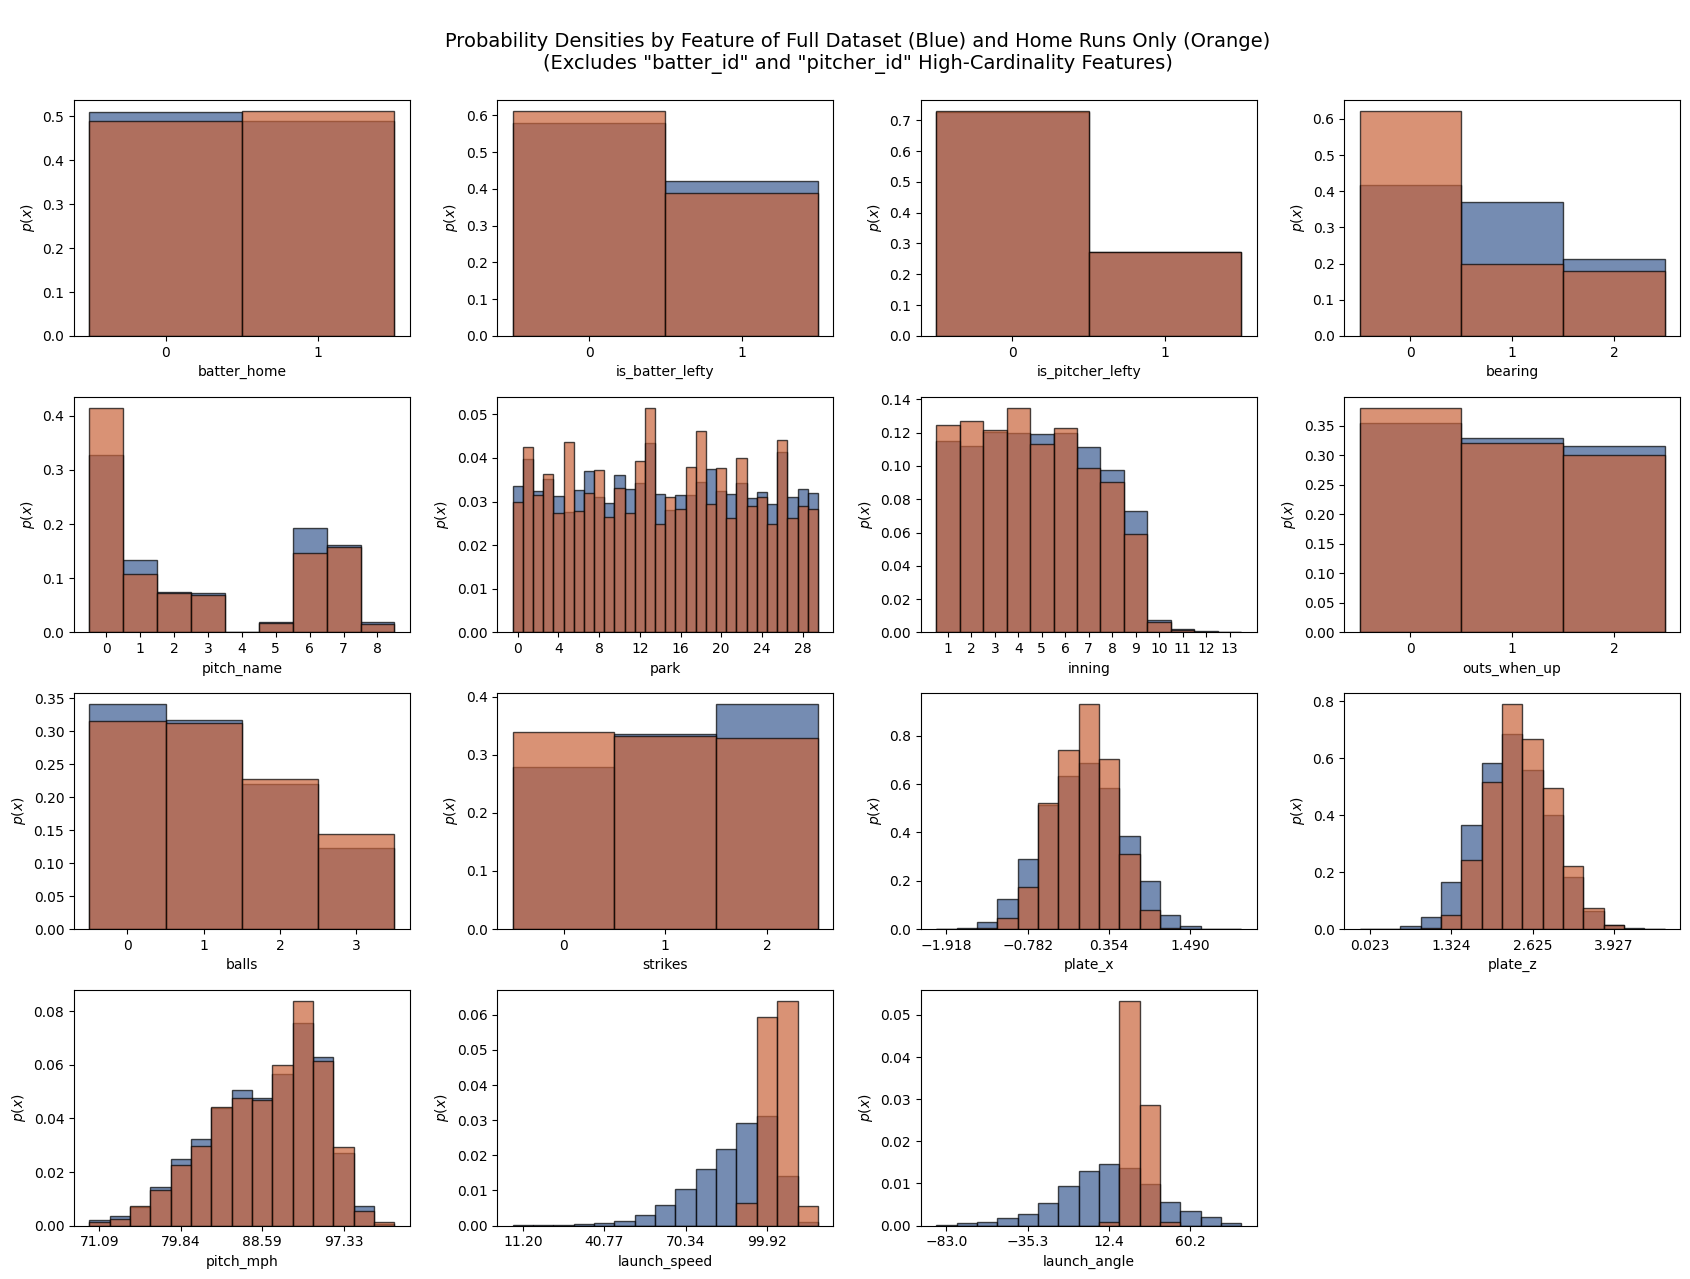

In [6]:
## A histogram will be plotted for each feature (except "batter_id" and "pitcher_id" which are high cardinality features)
## showing the distribution (density) of the feature's values/categories as a whole and when only home run samples are
## considered ("is_home_run" = 1). This should help give an idea of what features are most predictive of home runs.
cols_to_plot = np.array(
    [colname for colname in batting_df.columns if colname not in ['batter_id', 'pitcher_id']]
).reshape(4,4)

print(cols_to_plot)
print()

## Isolating the entries corresponding to a home run
home_run_entries = batting_df[batting_df['is_home_run'] == 1]

## Creating the histogram
fig, axs = plt.subplots(nrows=cols_to_plot.shape[0], ncols=cols_to_plot.shape[1], figsize=(17,13))
for row in range(cols_to_plot.shape[0]):
    for col in range(cols_to_plot.shape[1]):
        feature = cols_to_plot[row, col]
        
        if feature == 'is_home_run':
            axs[row, col].axis('off')
            continue
        
        to_plot_full_df = batting_df[feature]
        to_plot_hr_only = home_run_entries[feature]
        
        if to_plot_full_df.dtype != 'float64':
            if to_plot_full_df.dtype == 'O':
                if feature == 'park':
                    ## Reverting back to the original "park" encoding for the histogram
                    inv_park_names = {value: key for key, value in park_names.items()}
                    to_plot_full_df = to_plot_full_df.replace(inv_park_names)
                    to_plot_hr_only = to_plot_hr_only.replace(inv_park_names)
                    
                    print('Before binning the categorical feature "PARK", ', end='')
                    print('integers 0 to 29 where assigned to the categories in this order:')
                    print('~~~~~')
                    
                    for integer, parkname in park_names.items():
                        print(str(integer)+':', parkname)
                    
                    print()
                    
                else:
                    enc = OrdinalEncoder()
                    ## "reshape(-1, 1)" will create a 2D array where each sample is a row array with 1 entry (1 feature)
                    ## In other words (n_samples, n_features) = (n_samples, 1). "reshape(-1)" flattens the array
                    to_plot_full_df = enc.fit_transform(to_plot_full_df.to_numpy().reshape(-1, 1)).reshape(-1)
                    to_plot_hr_only = enc.transform(to_plot_hr_only.to_numpy().reshape(-1, 1)).reshape(-1)
                    
                    print('Before binning the categorical feature "{}", '.format(feature.upper()), end='')
                    print('integers 0 to {} where assigned to the categories in this order:'.format(len(enc.categories_[0])-1))
                    print('~~~~~')
                    
                    for integer, category in zip(range(len(enc.categories_[0])), enc.categories_[0]):
                        print(str(integer)+':', category)
                    
                    print()
                
            ## As all features binned in this conditional are (or are encoded as) integers, bins will be centered on the integers
            bins = np.arange(to_plot_full_df.min()-0.5, to_plot_full_df.max()+1.5)
                
        else:
            bins = 15 ## For continuous values
                
        _, binedges, _ = axs[row, col].hist(
            to_plot_full_df, 
            bins=bins, 
            density=True, 
            color='xkcd:denim blue', 
            alpha=0.7,
            edgecolor='black'
        )
            
        axs[row, col].hist(
            to_plot_hr_only, 
            bins=binedges, ## Uses the bin edges from the histograms of the full dataset so the same bins are used here
            density=True, 
            color='xkcd:terra cotta', 
            alpha=0.7,
            edgecolor='black'
        )
            
        binwidth = binedges[1] - binedges[0]
        bincenters = np.arange(binedges[0]+binwidth/2., binedges[-1]+binwidth/2., binwidth)
            
        if len(bincenters) < 15:
            axs[row, col].set_xticks(bincenters)
        else:
            axs[row, col].set_xticks(bincenters[::4])  ## To avoid over-crowding
        axs[row, col].set_xlabel(feature)
        axs[row, col].set_ylabel(r'$p(x)$')

fig.suptitle(
    '''
    Probability Densities by Feature of Full Dataset (Blue) and Home Runs Only (Orange)
    (Excludes "batter_id" and "pitcher_id" High-cardinality Features)
    ''', 
    fontsize=14
)

plt.tight_layout()

figname = 'feature_histograms_all_entries_and_home_runs_only.pdf'

print('Saving figure...')
plt.savefig(figname)
print('{} saved!'.format(figname))

plt.show()

In [7]:
## Creating a pairplot to look at bivariate (2 features) distributions of the dataset
## Looking at just the continuous variables, 
## particularly to look at "launch_speed" vs. "launch_angle" and "plate_x" vs. "plate_z"
## Separate plots could be made for continuous vs. discrete and discrete vs. discrete features
## These plots would probably best serve the viewer if they were heatmaps showing the percentages
## of samples in a given bin or at a discrete point that are home runs.
continuous_features = ['plate_x', 'plate_z', 'pitch_mph', 'launch_speed', 'launch_angle']

pairplot = sns.pairplot(
    batting_df,
    hue='is_home_run',
    palette={0: 'xkcd:denim blue', 1: 'xkcd:terra cotta'},
    vars=continuous_features,
    kind='hist', ## Off-diagonal plots will be 2D histograms
    diag_kind='kde', ## Plots on the diagonal will be kernel density estimates (KDEs)
    dropna=True,
    diag_kws={'common_norm': False} ## Each density is normalized independently
)

## Adding bivariate KDE plots to the lower corner of the pairplot
## KDE represents the data using a continuous probability density curve
## Overlaying these contours helps show the distribution of the data,
## particularly the non-home runs that have their histograms partially hidden
## by the histograms of the samples that are home runs.
## The upper corner is left as is so the histograms can be seen more clearly
## The contours are iso-proportions of the density:
## For example, 20% of the probability mass will lie *below* the contour given
## the level value of 0.2.
## The "levels" parameter can be an integer (evenly spaced contours with the 
## lowest level controlled by the "thresh" parameter) or an array of specified
## iso-proportions of the density

## Given I am plotting KDEs to broadly elucidate the distributions of the two data sets (HRs vs not HRs), 
## and that the feature distributions are vaguely Gaussian, I am setting my contour levels at 1 and 2 sigma

pairplot.map_lower(
    sns.kdeplot, 
    levels=[0.05, 0.32], 
    common_norm=False, 
    linewidths=0.8
)

figname = 'continuous_feature_pairplot_HRs_and_nonHRs.pdf'

print('Saving figure...')
plt.savefig(figname)
print('{} saved!'.format(figname))

plt.show()

/tmp/ipykernel_3705/3324587608.py:21: RuntimeWarning: invalid value encountered in divide
  hr_percentages = np.multiply(np.divide(speed_vs_angle_hist_hr, speed_vs_angle_hist), 100.)


Saving figure...
launch_speed_vs_launch_angle_heatmaps_sample_counts_hr_percentages.pdf saved!


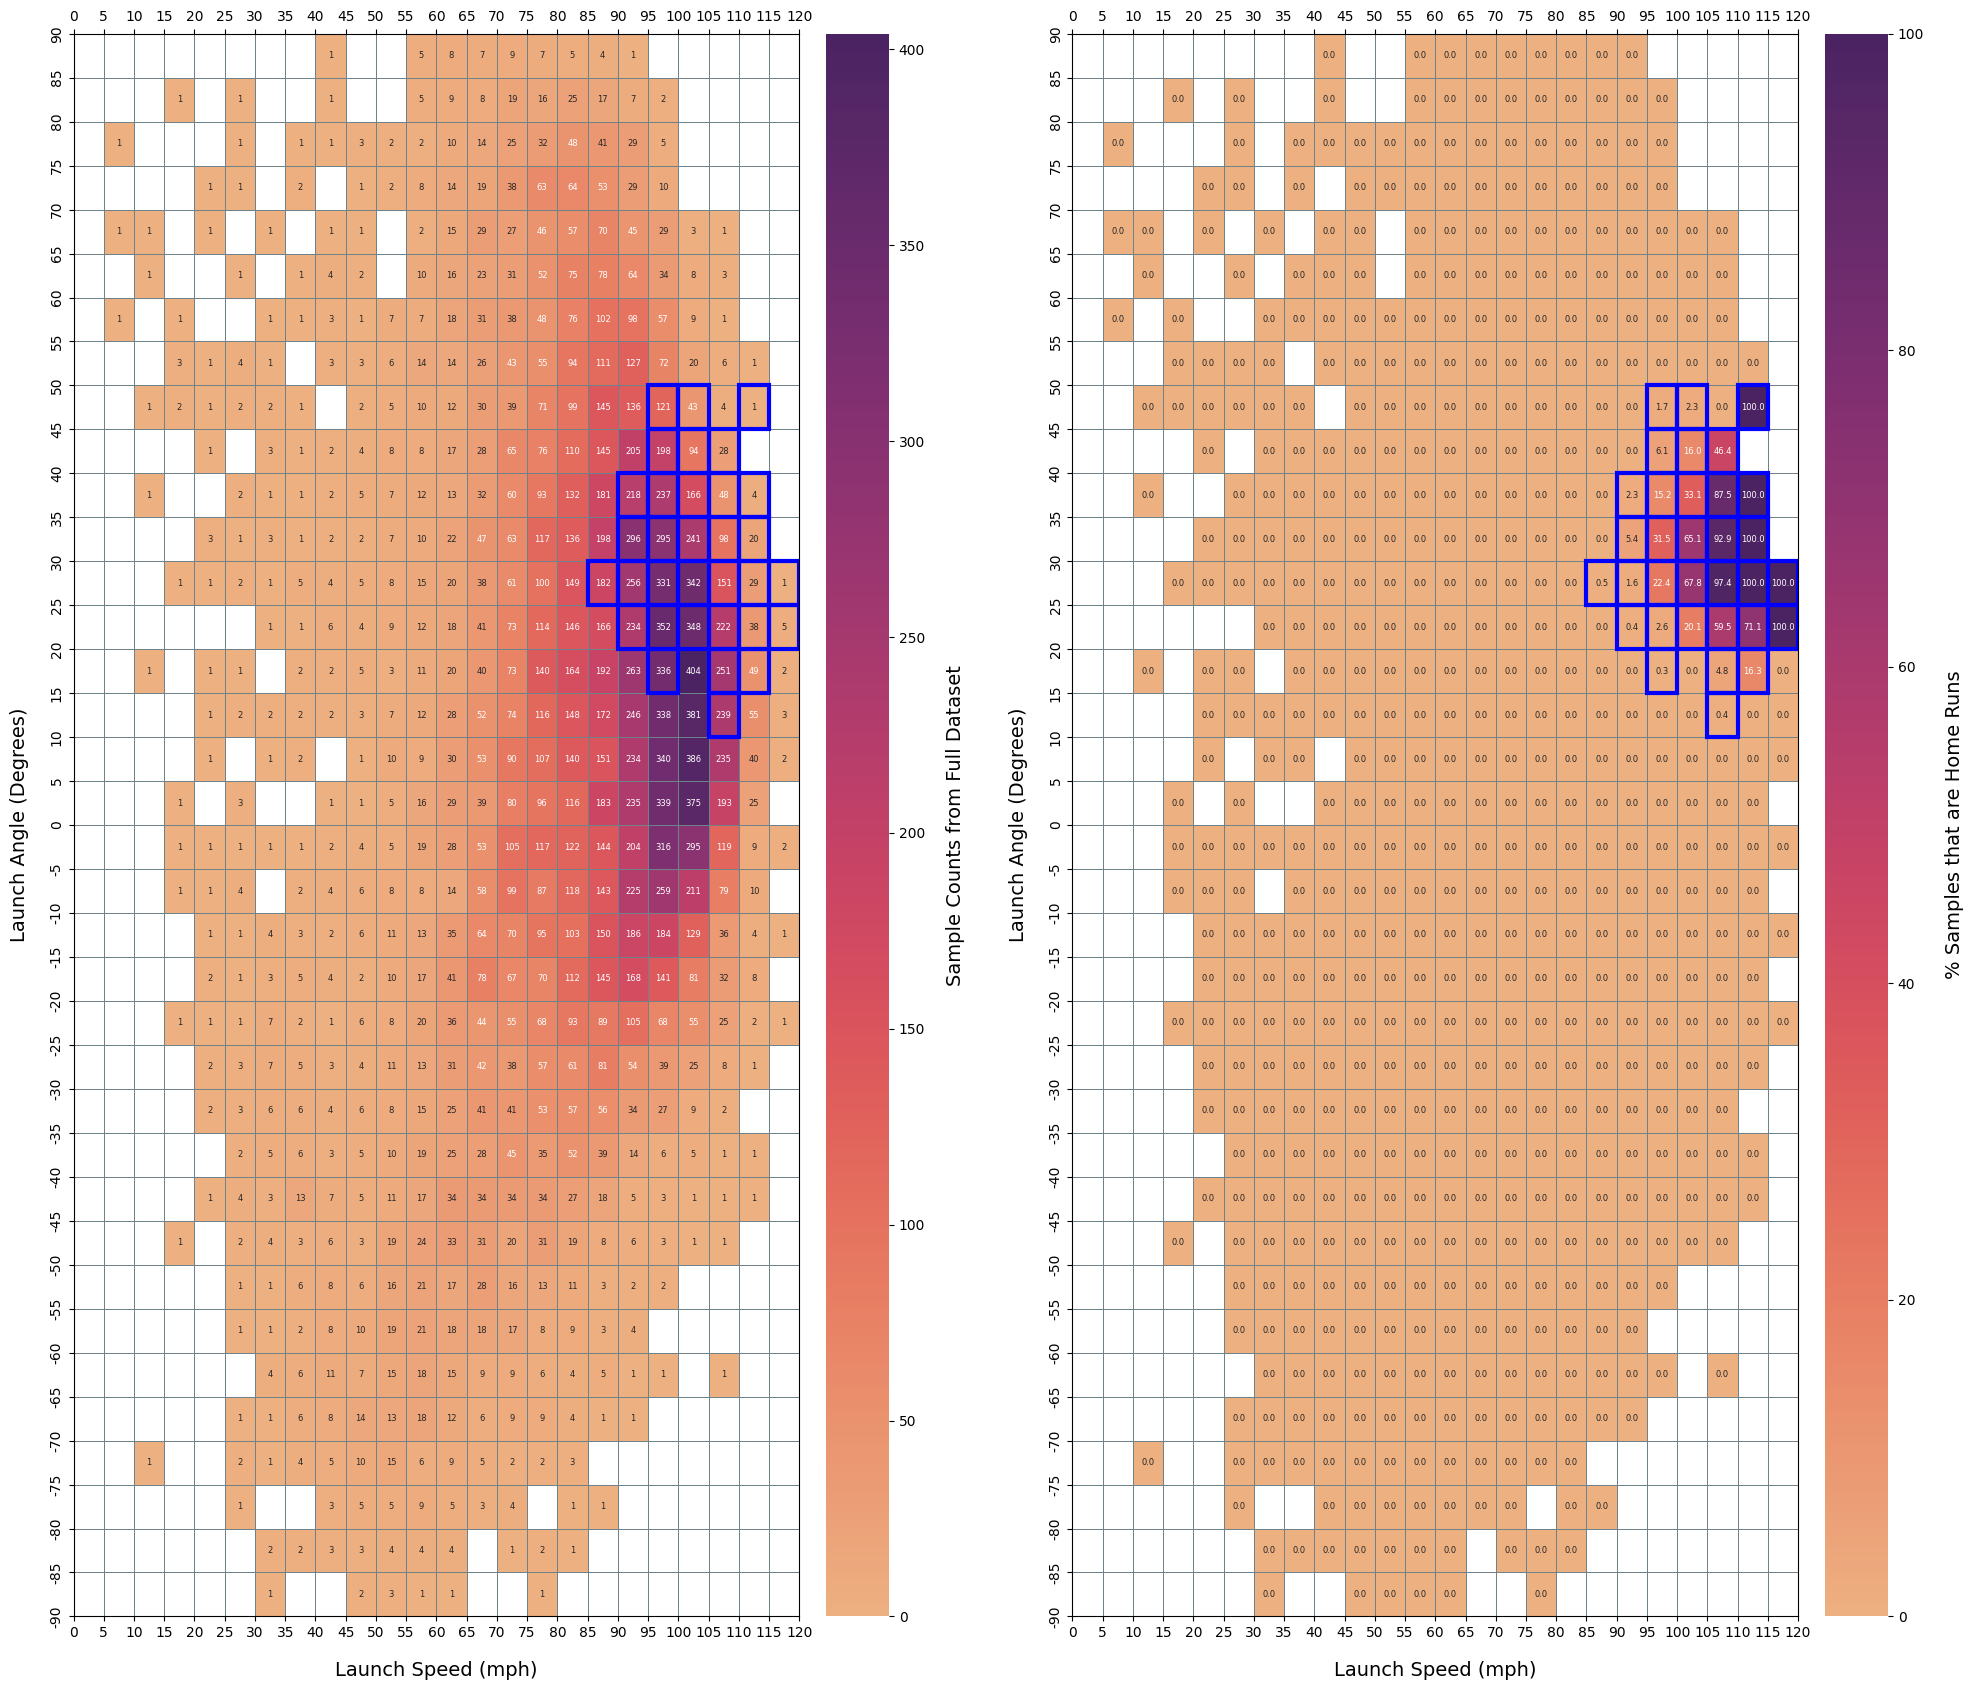

In [8]:
## The most predictive features clearly appear to be "launch_speed" and "launch_angle," which makes sense given physics.
## To really bring this home, I am generating a heat map, using these two features, of the percentage of samples in a bin
## that correspond to home runs. A second similar plot will show the number of total samples in those bins to show where
## the parameter space is well-sampled or not.

## This histogram does NOT follow the Cartesian convention where "x" is horizontal and "y" is vertical.
## Rather, "x" is binned along the first dimension of the array (vertical) and "y" along the second dimenstion (horizontal).
## Therefore, I will treat the "x" I want ("launch_speed") as "y," and the "y" I want ("launch_angle") as "x."
speed_vs_angle_hist, angle_edges, speed_edges = np.histogram2d(
    batting_df['launch_angle'], 
    batting_df['launch_speed'],
    bins=[np.arange(-90,95,5), np.arange(0,125,5)]
)

speed_vs_angle_hist_hr, _, _ = np.histogram2d(
    home_run_entries['launch_angle'], 
    home_run_entries['launch_speed'],
    bins=[angle_edges, speed_edges]
)

hr_percentages = np.multiply(np.divide(speed_vs_angle_hist_hr, speed_vs_angle_hist), 100.)

# print(speed_vs_angle_hist.shape)
# print(speed_vs_angle_hist_hr.shape)
# print(hr_percentages.shape)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,17))
## Since my bins in "np.histogram2d" had to be monotonically increasing when provided, here, 
## to have -90 launch angle at the origin instead of at the top of the heatmap, I have to flip the histograms
## along axis 0 (up/down) with "np.flipud"
counts = sns.heatmap(
    np.flipud(speed_vs_angle_hist),
    vmin=0,
    cmap='flare',
    annot=True,
    fmt='.0f',
    annot_kws={'fontsize': 6},
    linewidths=0.5,
    linecolor='xkcd:steel grey',
    cbar=True,
    cbar_kws={'aspect': 25, 'pad': 0.03},
    ## Mask out bins (count=0 in this heatmap) where "hr_percentages" is NaN (automatically masked in that heatmap)
    mask=np.flipud(np.isnan(hr_percentages)), ## "np.isnan" returns a needed Boolean array
    ax=ax1
)

## The colorbar label is added separately in order to allow more freedom to set parameters
counts_cbar = counts.collections[0].colorbar
counts_cbar.set_label('Sample Counts from Full Dataset', fontsize=14, labelpad=15)

counts.set_xticks(range(len(speed_edges)))
counts.set_xticklabels(speed_edges)
counts.tick_params(top=True, labeltop=True) ## Showing launch speed bins at the top and bottom for viewing convenience
counts.set_xlabel('Launch Speed (mph)', fontsize=14, labelpad=15)

counts.set_yticks(range(len(angle_edges)))
counts.set_yticklabels(angle_edges[::-1]) ## Reversing these labels to match the flip in the histogram along axis 0
counts.set_ylabel('Launch Angle (Degrees)', fontsize=14, labelpad=15)

counts.spines.left.set_visible(True)
counts.spines.bottom.set_visible(True)
counts.spines.right.set_visible(True)
counts.spines.top.set_visible(True)

percentages = sns.heatmap(
    np.flipud(hr_percentages), 
    vmin=0.,
    vmax=100.,
    cmap='flare',
    annot=True,
    fmt='.1f',
    annot_kws={'fontsize': 6},
    linewidths=0.5,
    linecolor='xkcd:steel grey',
    cbar=True,
    cbar_kws={'aspect': 25, 'pad': 0.03},
    ax=ax2
)

percentages_cbar = percentages.collections[0].colorbar
percentages_cbar.set_label('% Samples that are Home Runs', fontsize=14, labelpad=15)

percentages.set_xticks(range(len(speed_edges)))
percentages.set_xticklabels(speed_edges)
percentages.tick_params(top=True, labeltop=True) ## Showing launch speed bins at the top and bottom for viewing convenience
percentages.set_xlabel('Launch Speed (mph)', fontsize=14, labelpad=15)

percentages.set_yticks(range(len(angle_edges)))
percentages.set_yticklabels(angle_edges[::-1]) 
percentages.set_ylabel('Launch Angle (Degrees)', fontsize=14, labelpad=15)

percentages.spines.left.set_visible(True)
percentages.spines.bottom.set_visible(True)
percentages.spines.right.set_visible(True)
percentages.spines.top.set_visible(True)

## Adding boxes (Rectangle patches) around the cells with non-zero home run percentages
## as well as around the corresponding cells reporting sample count
## to make matching the cells between heatmaps easier. 
## Now we can see where in "launch speed" vs. "launch angle" parameter space home runs are hit (a tight cluster),
## as well as how well sampled the binned parameter space is.
nonzero_percentages = np.where(np.flipud(hr_percentages) > 0.)

# print(nonzero_percentages)

for cell_count_x, cell_count_y in zip(nonzero_percentages[1], nonzero_percentages[0]):
    ## Unfortunately, an error was raised when I tried to use the same artist on both axes.
    ## So I had to specify the Rectangle patches for each axis separately.
    ax1.add_patch(
        Rectangle(
            (cell_count_x, cell_count_y), 
            width=1, 
            height=1, 
            fill=False, 
            edgecolor='blue', 
            linewidth=3
        )
    )
    
    ax2.add_patch(
        Rectangle(
            (cell_count_x, cell_count_y), 
            width=1, 
            height=1, 
            fill=False, 
            edgecolor='blue', 
            linewidth=3
        )
    )

plt.tight_layout(w_pad=2) ## "w_pad" adjusts padding between the columns (ax1 and ax2)

figname = 'launch_speed_vs_launch_angle_heatmaps_sample_counts_hr_percentages.pdf'

print('Saving figure...')
plt.savefig(figname)
print('{} saved!'.format(figname))

plt.show()

In [9]:
## Due to the apparent highly predictive nature of the features "launch_speed" and "launch_angle,"
## I am going to remove the samples (3212 in total out of 46244 total samples) that are missing both features.
## For those samples missing only one of the two features, I will attempt to impute the value of the missing feature.
## I suspect that if samples missing both features were retained, given how predictive the features appear to be, 
## those samples would do very little to improve the predictive model and may actually hurt the model.

batting_df = batting_df[~((batting_df['launch_speed'].isna()) & (batting_df['launch_angle'].isna()))]

print('Mean launch speed: {:.1f} mph'.format(batting_df['launch_speed'].mean())) ## For future reference 
print('Mean launch angle: {:.1f} degrees'.format(batting_df['launch_angle'].mean())) ## For future reference

batting_df

Mean launch speed: 88.0 mph
Mean launch angle: 12.5 degrees


,batter_id,pitcher_id,batter_home,is_batter_lefty,is_pitcher_lefty,bearing,pitch_name,park,inning,outs_when_up,balls,strikes,plate_x,plate_z,pitch_mph,launch_speed,launch_angle,is_home_run
0,571448,592662,0,0,1,left,Slider,Chase Field,1,0,1,2,-0.15,1.97,87.8,108.9,9.0,0
1,571448,592662,1,0,1,left,4-Seam Fastball,Coors Field,1,1,3,1,-0.71,2.88,95.2,NaN,18.0,0
2,571448,592662,1,0,1,left,Slider,Coors Field,3,0,1,2,-0.54,1.75,86.5,75.0,49.0,0
3,453568,592662,0,1,1,right,Slider,Chase Field,1,0,0,2,-0.42,3.15,86.7,90.6,54.0,0
4,453568,592662,1,1,1,left,4-Seam Fastball,Coors Field,1,1,1,0,0.18,3.27,96.1,NaN,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46239,605170,672911,1,1,0,right,Slider,Wrigley Field,7,1,2,2,0.25,2.81,80.9,98.9,26.0,0
46240,475253,501303,0,1,0,left,Curveball,Target Field,9,2,0,1,-0.56,2.04,72.4,93.8,35.0,0
46241,673357,666622,1,0,1,center,4-Seam Fastball,Guarantee Rate Park,8,2,0,0,0.16,3.10,97.7,105.6,NaN,0
46242,608577,666622,1,1,1,left,Slider,Guarantee Rate Park,8,2,2,2,0.26,2.85,83.9,99.2,14.0,0


Feature: BATTER_ID
Categories with 0 or undefined variance: 154 / 576 categories
Categories with count < 25: 145 / 576: 25.17%

Feature: PITCHER_ID
Categories with 0 or undefined variance: 135 / 730 categories
Categories with count < 25: 219 / 730: 30.00%

Feature: BEARING
Categories with 0 or undefined variance: 0 / 3 categories

Feature: PITCH_NAME
Categories with 0 or undefined variance: 1 / 9 categories

Feature: PARK
Categories with 0 or undefined variance: 0 / 30 categories

Saving figure...
counts_vs_target_variance_lambda_target_mean_for_feature_categories.pdf saved!


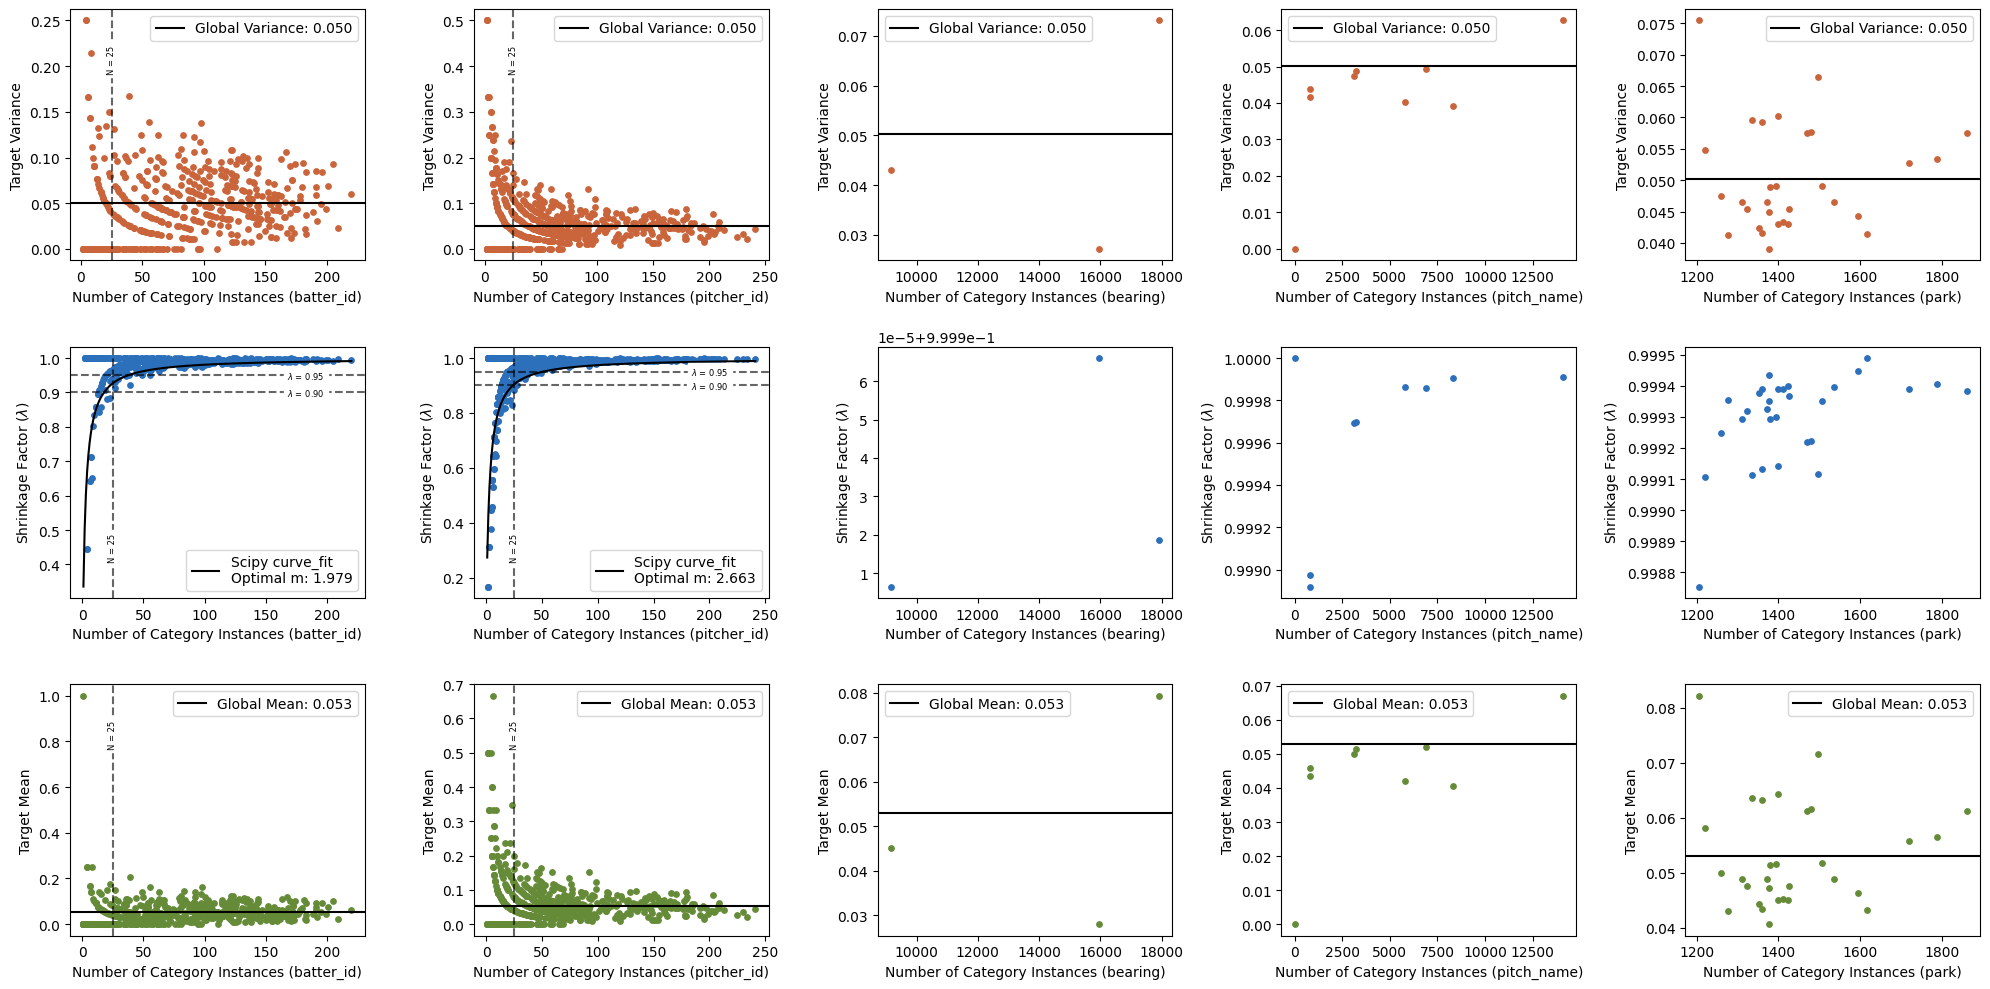

,len,var,mean,lambda
batter_id,,,,
425784,1,nan,0.000000,nan
466988,1,nan,0.000000,nan
572073,1,nan,0.000000,nan
596144,1,nan,0.000000,nan
599096,1,nan,0.000000,nan
606213,1,nan,0.000000,nan
664314,1,nan,0.000000,nan
664334,1,nan,0.000000,nan
666969,1,nan,0.000000,nan


In [10]:
## Here I want to inspect the categorical features ("batter_id", "pitcher_id", "bearing", "pitch_name", "park")
## to see which target encoder, the scikit-learn TargetEncoder or the custom TargetEncode above,
## may make more sense to use with each feature. TargetEncoder has a smoothing factor based on a category's 
## variance of the target, "is_home_run" (y), while TargetEncode has a smoothing factor based on a category's
## total number of observations. See markup near beginning of this notebook for more details, especially
## when considering why the custom TargetEncode may be best for the features "batter_id" and "pitcher_id."

def lambda_(count, m):
    return count / (count + m)

categorical_features = ['batter_id', 'pitcher_id', 'bearing', 'pitch_name', 'park']

global_target_var  = np.var(batting_df['is_home_run'])  ## Target variance considering all samples
global_target_mean = np.mean(batting_df['is_home_run']) ## Target mean considering all samples

dfs_display = '' ## To display DataFrames side-by-side instead of on top of each other (see "for" loop)

fig, axs = plt.subplots(nrows=3, ncols=len(categorical_features), figsize=(20,10))

text_kws = {'ha': 'center', 'va': 'center', 'backgroundcolor': 'white', 'fontsize': 6} ## For later added annotations

## Comment out lines 24 and 25 as these are used for an equivalency test between the results of this cell
## and the results of the custom class "ModifiedTargetEncoder" 
encoded_features = np.empty((batting_df.shape[0], len(categorical_features)), dtype=np.float64)
m_factors = {}

for i, feature in enumerate(categorical_features):
    ## Finding the target variance, target mean, and count of each category in a given feature
    feature_groupby = (batting_df
                       .groupby(feature)
                       .agg({'is_home_run': (len, np.var, np.mean)})
                       .droplevel(0, axis=1)
                       .sort_values(by=['len', 'var'], ascending=True)
                      )
    
    ## Calculating the shrinkage factor for each category i as in the scikit-learn TargetEncoder: 
    ## lambda_i = n_i / (m_i + n_i)
    ## n_i is the number of samples with category i, and m_i is the smoothing factor for category i
    ## By default, m_i is an empirical Bayes estimate: m_i = sigma_i^2 / tau^2 
    ## sigma_i^2 is the target variance with category i, and tau^2 is the global target variance.
    ## Plotting lambda_i against n_i will show roughly when n_i dominates the lambda_i equation here
    ## and lambda_i approaches 1, meaning where the TargetEncoder encoding for category i is roughly equal 
    ## to the target mean for samples with category i and negligibly smoothed by the global target mean.
    ## This will help to appropriately calibrate the custom target encoder if/when it is used.
    ## See markup and custom target encoder definition near beginning of this notebook for more details.
    smooth_bayes = feature_groupby['var'] / global_target_var
    feature_groupby['lambda'] = feature_groupby['len'] / (feature_groupby['len'] + smooth_bayes)

    ## To display DataFrames side-by-side instead of on top of each other
    ## https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
    dfs_display += (feature_groupby
                    .style
                    .set_table_attributes("style='display:inline'")
                    .set_caption('Sorted by count ("len") then by variance')
                    ._repr_html_()
                   )
    dfs_display += '&emsp;' ## A HTML tab for spacing between DataFrames
    
    print('Feature: '+feature.upper())
    print('Categories with 0 or undefined variance: {} / {} categories'
          .format(len(feature_groupby[~(feature_groupby['var'] > 0.)]),
                  len(feature_groupby)
                 )
         )
    ## First row of plot
    ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    axs[0,i].scatter(
        feature_groupby['len'], 
        feature_groupby['var'], 
        color='xkcd:terra cotta', 
        marker='o', 
        s=15
    )
    axs[0,i].axhline(
        y = global_target_var, 
        linestyle='-', 
        linewidth=1.5, 
        color='black', 
        label='Global Variance: {:.3f}'.format(global_target_var)
    )
    if (feature == 'batter_id') | (feature == 'pitcher_id'):
        axs[0,i].axvline(x = 25, linestyle='--', linewidth=1.5, color='black', alpha=0.6)
        ## x coordinates will be data, y coordinates will be Axes
        transv = transforms.blended_transform_factory(axs[0,i].transData, axs[0,i].transAxes)
        axs[0,i].text(25, 0.8, 'N = 25', rotation='vertical', transform=transv, **text_kws)
    axs[0,i].set_xlabel('Number of Category Instances ({})'.format(feature))
    axs[0,i].set_ylabel('Target Variance')
    axs[0,i].legend(loc='best')
    
    ## Second row of plot
    ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    axs[1,i].scatter(
        feature_groupby['len'],
        feature_groupby['lambda'],
        color='xkcd:medium blue',
        marker='o',
        s=15
    )
    axs[1,i].set_xlabel('Number of Category Instances ({})'.format(feature))
    axs[1,i].set_ylabel(r'Shrinkage Factor ($\lambda$)')
    
    if (feature == 'batter_id') | (feature == 'pitcher_id'):
        ## It has just occurred to me that for the scikit-learn TargetEncoder,
        ## the smoothing factor, "m," can be given a float value by the user
        ## through the keyword parameter "smooth." This float would then be used
        ## for all categories in a feature. So, using the samples with non-zero
        ## variance, a rough curve can be fit by feature to count vs. lambda to estimate
        ## m in the functional form used by TargetEncoder, lambda = count / (count+m)
        non_zero_var_df = feature_groupby[(~feature_groupby['lambda'].isna()) & 
                                          (feature_groupby['var'] != 0.)
                                         ]   
        ## "lambda_" function definition is at the top of the cell
        ## Non-linear least squares
        ## "nan_policy" keyword was added in scipy v1.11. I currently have v1.10.1.
        m_opt, _ = curve_fit(lambda_, non_zero_var_df['len'], non_zero_var_df['lambda'])
        
        axs[1,i].plot(
            feature_groupby['len'], 
            lambda_(feature_groupby['len'], m_opt[0]), 
            linestyle='-', 
            linewidth=1.5, 
            color='black',
            label='Scipy curve_fit\nOptimal m: {:.3f}'.format(m_opt[0])
        )
        axs[1,i].legend(loc='best')

        axs[1,i].axvline(x = 25, linestyle='--', linewidth=1.5, color='black', alpha=0.6)
#         axs[1,i].axvline(x = 100, linestyle='--', linewidth=1.5, color='black')
        ## x coordinates will be data, y coordinates will be Axes
        transv = transforms.blended_transform_factory(axs[1,i].transData, axs[1,i].transAxes)
        axs[1,i].text(25, 0.2, 'N = 25', rotation='vertical', transform=transv, **text_kws)
        
        axs[1,i].axhline(y = 0.90, linestyle='--', linewidth=1.5, color='black', alpha=0.6)
        axs[1,i].axhline(y = 0.95, linestyle='--', linewidth=1.5, color='black', alpha=0.6)
#         axs[1,i].axhline(y = 0.99, linestyle='--', linewidth=1.5, color='black')
        ## x coordinates will be Axes, y coordinates will be data
        transh = transforms.blended_transform_factory(axs[1,i].transAxes, axs[1,i].transData)
        axs[1,i].text(0.8, 0.90, r'$\lambda$ = 0.90', transform=transh, **text_kws)
        axs[1,i].text(0.8, 0.95, r'$\lambda$ = 0.95', transform=transh, **text_kws)
        
        print('Categories with count < 25: {} / {}: {:.2f}%'
              .format(len(feature_groupby[feature_groupby['len'] < 25]),
                      len(feature_groupby),
                      float(len(feature_groupby[feature_groupby['len'] < 25]))/len(feature_groupby)*100.
                     )
             )

## Comment out lines 150 through 159 as these are used for an equivalency test between the results of this cell
## and the results of the custom class "ModifiedTargetEncoder" 
        m_factors[feature] = m_opt[0]
    
    elif feature == 'pitch_name':
        m_factors[feature] = np.mean([m_factors['batter_id'], m_factors['pitcher_id']])
        
    else:
        m_factors[feature] = 'auto'
        
    te = TargetEncoder(target_type='binary', smooth=m_factors[feature], random_state=0)
    encoded_features[:,i] = te.fit_transform(batting_df.loc[:,[feature]], batting_df['is_home_run']).flatten()

        
    ## Third row of plot
    ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    axs[2,i].scatter(
        feature_groupby['len'], 
        feature_groupby['mean'], 
        color='xkcd:moss green', 
        marker='o', 
        s=15
    )
    axs[2,i].axhline(
        y = global_target_mean, 
        linestyle='-', 
        linewidth=1.5, 
        color='black', 
        label='Global Mean: {:.3f}'.format(global_target_mean)
    )
    if (feature == 'batter_id') | (feature == 'pitcher_id'):
        axs[2,i].axvline(x = 25, linestyle='--', linewidth=1.5, color='black', alpha=0.6)
        ## x coordinates will be data, y coordinates will be Axes
        transv = transforms.blended_transform_factory(axs[2,i].transData, axs[2,i].transAxes)
        axs[2,i].text(25, 0.8, 'N = 25', rotation='vertical', transform=transv, **text_kws)
    axs[2,i].set_xlabel('Number of Category Instances ({})'.format(feature))
    axs[2,i].set_ylabel('Target Mean')
    axs[2,i].legend(loc='best')
    
    print()
    
plt.tight_layout(h_pad=2) ## "h_pad" adjusts padding between the rows of the figure

figname = 'counts_vs_target_variance_lambda_target_mean_for_feature_categories.pdf'

print('Saving figure...')
plt.savefig(figname)
print('{} saved!'.format(figname))

plt.show()
display_html(dfs_display, raw=True) ## Currently displays DataFrames in their entirety

## Comment out the below line as it is used for an equivalency test between the results of this cell
## and the results of the custom class "ModifiedTargetEncoder" 
encoded_features_df = pd.DataFrame(encoded_features, columns=categorical_features)

In [11]:
## Comment out this cell in its entirety
## It is used for an equivalency test between the results of the above cell
## and the results of the custom class "ModifiedTargetEncoder" here

mte = ModifiedTargetEncoder(
    target_type='binary',
    smooth='by_feature',
    fit_feature_smooth_factor=['batter_id', 'pitcher_id'],
    avg_smooth_factors=['pitch_name'],
    random_state=0
)

custom_class_enc = mte.fit_transform(batting_df.loc[:,categorical_features], batting_df['is_home_run'])

custom_class_enc_df = pd.DataFrame(custom_class_enc, columns=categorical_features)

print('The target encoding in the above cell is equivalent to the target encoding with the custom class: ', end='')
print(encoded_features_df.round(5).equals(custom_class_enc_df.round(5)))
print()
print('The smoothing factors determined in the above cell (left) vs. determined with the custom class (right):\n')
print('{:<10}\t{:<4}\t{:<5}\t{:<5}'.format('Feature', 'Cell', 'Class', 'Equiv'))
print('---------------------------------------')
for feature in m_factors.keys():
    if isinstance(m_factors[feature], str):
        print('{:<10}:\t{:<4}\t{:<4}\t{}'
              .format(feature, 
                      m_factors[feature], 
                      mte.smoothing_factors_[feature],
                      m_factors[feature] == mte.smoothing_factors_[feature]
                     )
             )
    else:
        print('{:<10}:\t{:.4f}\t{:.4f}\t{}'
              .format(feature, 
                      m_factors[feature], 
                      mte.smoothing_factors_[feature],
                      round(m_factors[feature],4) == round(mte.smoothing_factors_[feature],4)
                     )
             )

display(encoded_features_df.round(5))
display(custom_class_enc_df.round(5))
print(mte.get_feature_names_out()) ## Testing class method

The target encoding in the above cell is equivalent to the target encoding with the custom class: True

The smoothing factors determined in the above cell (left) vs. determined with the custom class (right):

Feature   	Cell	Class	Equiv
---------------------------------------
batter_id :	1.9792	1.9792	True
pitcher_id:	2.6627	2.6627	True
bearing   :	auto	auto	True
pitch_name:	2.3209	2.3209	True
park      :	auto	auto	True


,batter_id,pitcher_id,bearing,pitch_name,park
0,0.04490,0.08651,0.02814,0.05253,0.04787
1,0.06236,0.10175,0.02819,0.06716,0.04722
2,0.04490,0.08651,0.02814,0.05253,0.04581
3,0.04557,0.10175,0.04621,0.05241,0.04562
4,0.03041,0.08651,0.02814,0.06751,0.04581
...,...,...,...,...,...
43027,0.01675,0.02493,0.04493,0.05035,0.04687
43028,0.06518,0.05301,0.02814,0.05177,0.05433
43029,0.10868,0.03027,0.07954,0.06751,0.06303
43030,0.01399,0.03027,0.02813,0.05035,0.06226


,batter_id,pitcher_id,bearing,pitch_name,park
0,0.04490,0.08651,0.02814,0.05253,0.04787
1,0.06236,0.10175,0.02819,0.06716,0.04722
2,0.04490,0.08651,0.02814,0.05253,0.04581
3,0.04557,0.10175,0.04621,0.05241,0.04562
4,0.03041,0.08651,0.02814,0.06751,0.04581
...,...,...,...,...,...
43027,0.01675,0.02493,0.04493,0.05035,0.04687
43028,0.06518,0.05301,0.02814,0.05177,0.05433
43029,0.10868,0.03027,0.07954,0.06751,0.06303
43030,0.01399,0.03027,0.02813,0.05035,0.06226


['batter_id' 'pitcher_id' 'bearing' 'pitch_name' 'park']


In [12]:
## Splitting the DataFrame into the feature set (X) and the target column (y)
X = batting_df.iloc[:,:-1] ## The unincluded column (the last column) is the target column
y = batting_df['is_home_run']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) ## 75/25 train/test split

categorical_columns = ['batter_id', 'pitcher_id', 'bearing', 'pitch_name', 'park']

ct = ColumnTransformer(
    [
        (
            'modified_target_encoder',
            ModifiedTargetEncoder(
                target_type='binary',
                smooth='by_feature',
                fit_feature_smooth_factor=['batter_id', 'pitcher_id'],
                avg_smooth_factors=['pitch_name'],
                random_state=0
            ),
            categorical_columns
        )
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# set_config(transform_output='pandas') ## Global - makes sklearn transformers output DataFrames

preprocessor = Pipeline(
    [
        ('modified_target_encoder', ct),
        ('scaler', MinMaxScaler()),
        ('imputer', 'passthrough')
    ]
)

cachedir = mkdtemp()
print('The path of the temporary directory where fitted transformers of the pipeline will be cached: ', cachedir)

pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ],
    memory=cachedir
)

pipe.set_output(transform='pandas') ## All transformers will output DataFrames. Feature names are preserved

param_grid = {
    'preprocessor__imputer': [SimpleImputer(strategy='mean'), KNNImputer()],
    'classifier__C': [1e-4, 1e-3, 1e-2, 1e-1, 1., 1e1, 1e2, 1e3, 1e4]
}
    
## All scorers follow the convention that *higher* return values are *better* than lower return values
## Thus, metrics which measure the distance between the model and the data, like *log-loss*, are available as
## "neg_log_loss," which returns the *negated* value of the metric

## Log-loss measures how close the prediction probability is to the corresponding *true* value
## (0 or 1 in binary classification). The more the predicted probability *diverges* from the actual value,
## the *higher* the log-loss value
## For a single sample with true label y in {0,1} and probability estimate p=Pr(y=1), the log-loss is:
## L(y,p) = -(yln(p) + (1-y)ln(1-p))
## In order to evaluate a model, log-loss score is reported as the average of log-losses of all the 
## observations/predictions. Log-loss is also known as "logistic loss" or "cross-entropy loss."
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring=['neg_log_loss', 'accuracy'],
    n_jobs=4,
    refit='neg_log_loss',
    error_score='raise',
    return_train_score=True
)

display(grid)

grid.fit(X_train, y_train)

rmtree(cachedir)

grid_results = pd.DataFrame(grid.cv_results_)

display(grid_results)
display(grid_results.iloc[[grid.best_index_]])

print('The best estimator yields a mean cross-validated score of {:.4f}'.format(grid.best_score_))
print()
print('The parameters that gave the best results on the hold-out data:')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
for k, v in grid.best_params_.items():
    print('{}: {}'.format(k, v))
print()
print('The scorer function used to choose the best parameters for the model: ', grid.scorer_)
print('The amount of time to refit the best model on the whole training set: {:.1f} seconds'.format(grid.refit_time_))

The path of the temporary directory where fitted transformers of the pipeline will be cached:  /tmp/tmp2vgl1cvn


GridSearchCV(error_score='raise',
             estimator=Pipeline(memory='/tmp/tmp2vgl1cvn',
                                steps=[('preprocessor',
                                        Pipeline(steps=[('modified_target_encoder',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('modified_target_encoder',
                                                                                          ModifiedTargetEncoder(avg_smooth_factors=['pitch_name'],
                                                                                                                fit_feature_smooth_factor=['batter_id',
                                                                                                                                           'pitcher_id'],
                                                                                                                random_state=0...
                                                                                           'pitch_name',
                                                                                           'park'])],
                                                                           verbose_feature_names_out=False)),
                                                        ('scaler',
                                                         MinMaxScaler()),
                                                        ('imputer',
                                                         'passthrough')])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=4,
             param_grid={'classifier__C': [0.0001, 10000.0],
                         'preprocessor__imputer': [SimpleImputer(),
                                                   KNNImputer()]},
             refit='neg_log_loss', return_train_score=True,
             scoring=['neg_log_loss', 'accuracy'])

/home/tim/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py:408: UserWarning: Persisting input arguments took 0.58s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  X, fitted_transformer = fit_transform_one_cached(
/home/tim/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py:408: UserWarning: Persisting input arguments took 0.59s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  X, fitted_transformer = fit_transform_one_cached(
/home/tim/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py:408: UserWarning: Persisting input arguments took 0.62s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_preprocessor__imputer,params,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss,split0_train_neg_log_loss,split1_train_neg_log_loss,split2_train_neg_log_loss,split3_train_neg_log_loss,split4_train_neg_log_loss,mean_train_neg_log_loss,std_train_neg_log_loss,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy
0,2.204286,0.188203,0.148113,0.051428,0.0001,SimpleImputer(),"{'classifier__C': 0.0001, 'preprocessor__imputer': SimpleImputer()}",-0.205000,-0.204996,-0.204995,-0.205441,-0.204993,-0.205085,0.000178,4,-0.205084,-0.205064,-0.205079,-0.204965,-0.205099,-0.205059,0.000048,0.947637,0.947637,0.947637,0.947483,0.947629,0.947605,0.000061,3,0.947597,0.947597,0.947597,0.947635,0.947599,0.947605,0.000015
1,111.502243,47.614853,48.949805,19.252257,0.0001,KNNImputer(),"{'classifier__C': 0.0001, 'preprocessor__imputer': KNNImputer()}",-0.204990,-0.204986,-0.204981,-0.205431,-0.204983,-0.205074,0.000179,3,-0.205073,-0.205053,-0.205072,-0.204955,-0.205088,-0.205048,0.000048,0.947637,0.947637,0.947637,0.947483,0.947629,0.947605,0.000061,3,0.947597,0.947597,0.947597,0.947635,0.947599,0.947605,0.000015
2,4.474300,0.640522,0.623902,0.034067,10000.0,SimpleImputer(),"{'classifier__C': 10000.0, 'preprocessor__imputer': SimpleImputer()}",-0.154870,-0.155224,-0.151659,-0.148108,-0.150082,-0.151988,0.002741,2,-0.147228,-0.147679,-0.149890,-0.150342,-0.150677,-0.149163,0.001425,0.949497,0.949961,0.949342,0.947947,0.949024,0.949154,0.000675,1,0.949843,0.950037,0.949378,0.949495,0.949032,0.949557,0.000353
3,4.605706,0.367818,84.010126,7.814008,10000.0,KNNImputer(),"{'classifier__C': 10000.0, 'preprocessor__imputer': KNNImputer()}",-0.152379,-0.152682,-0.143440,-0.145192,-0.148080,-0.148355,0.003719,1,-0.144329,-0.145127,-0.149114,-0.147250,-0.147756,-0.146715,0.001752,0.948722,0.949961,0.948567,0.948102,0.947939,0.948658,0.000712,2,0.949262,0.949301,0.948720,0.949417,0.949032,0.949146,0.000247


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_preprocessor__imputer,params,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss,split0_train_neg_log_loss,split1_train_neg_log_loss,split2_train_neg_log_loss,split3_train_neg_log_loss,split4_train_neg_log_loss,mean_train_neg_log_loss,std_train_neg_log_loss,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy
3,4.605706,0.367818,84.010126,7.814008,10000.0,KNNImputer(),"{'classifier__C': 10000.0, 'preprocessor__imputer': KNNImputer()}",-0.152379,-0.152682,-0.14344,-0.145192,-0.14808,-0.148355,0.003719,1,-0.144329,-0.145127,-0.149114,-0.14725,-0.147756,-0.146715,0.001752,0.948722,0.949961,0.948567,0.948102,0.947939,0.948658,0.000712,2,0.949262,0.949301,0.94872,0.949417,0.949032,0.949146,0.000247


The best estimator yields a mean cross-validated score of -0.1484

The parameters that gave the best results on the hold-out data:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
classifier__C: 10000.0
preprocessor__imputer: KNNImputer()

The scorer function used to choose the best parameters for the model:  {'neg_log_loss': make_scorer(log_loss, greater_is_better=False, response_method='predict_proba'), 'accuracy': make_scorer(accuracy_score, response_method='predict')}
The amount of time to refit the best model on the whole training set: 118.7 seconds


Saving figure...
gridsearch_mean_cv_scores_and_stds_vs_lr_inv_reg_strengths.pdf saved!


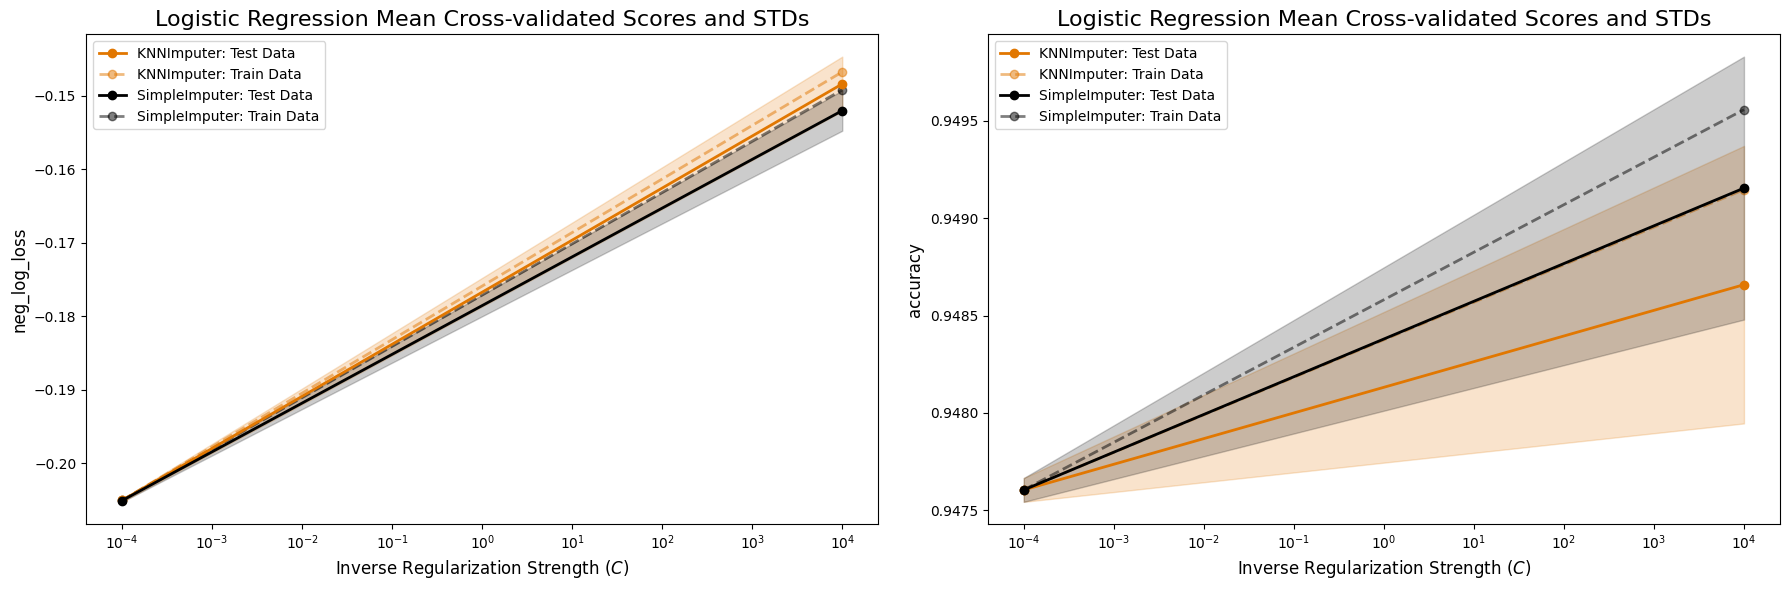

In [13]:
## Baseline log-loss score for a dataset is determined from the naive classification model,
## which pegs all observations with a constant probability equal to % of data with class 1 observations.
## https://towardsdatascience.com/intuition-behind-log-loss-score-4e0c9979680a

## Create plots to visualize the mean cross-validated scoring of the train/test data 
## using either imputer and any C value

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

for i, scorer in enumerate(['neg_log_loss', 'accuracy']):
    for imputer, color in zip(['KNNImputer()', 'SimpleImputer()'], ['xkcd:pumpkin', 'black']):
        ## The imputers given in "grid_results['param_imputer']" are not strings but instances and must be converted
        gr_subset = grid_results[grid_results['param_preprocessor__imputer'].astype(str) == imputer]
        
        for dataset, linestyle, alpha, zorder in zip(['test', 'train'], ['-', '--'], [1.0, 0.5], [10, 1]):
            axs[i].semilogx(
                gr_subset['param_classifier__C'], 
                gr_subset['mean_'+dataset+'_'+scorer],
                color=color,
                linestyle=linestyle,
                linewidth=2,
                marker='o',
                alpha=alpha,
                zorder=zorder,
                label='{}: {} Data'.format(imputer.split('(')[0], dataset.capitalize())
            )
            
            if dataset == 'test':
                axs[i].fill_between(
                    ## "gr_subset['param_classifier__C']" has dtype "object" and must be converted here
                    x =gr_subset['param_classifier__C'].astype(np.float64), 
                    y1=gr_subset['mean_test_'+scorer] + gr_subset['std_test_'+scorer],
                    y2=gr_subset['mean_test_'+scorer] - gr_subset['std_test_'+scorer],
                    color=color,
                    alpha=0.2
                )
    
    axs[i].legend(loc='upper left')
    axs[i].minorticks_off()
    axs[i].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1., 1e1, 1e2, 1e3, 1e4])
    axs[i].set_title('Logistic Regression Mean Cross-validated Scores and STDs', fontsize=16)
    axs[i].set_xlabel('Inverse Regularization Strength ($C$)', fontsize=12)
    axs[i].set_ylabel(scorer, fontsize=12)
    
plt.tight_layout(w_pad=2)

figname = 'gridsearch_mean_cv_scores_and_stds_vs_lr_inv_reg_strengths.pdf'

print('Saving figure...')
plt.savefig(figname)
print('{} saved!'.format(figname))

plt.show()

In [14]:
best_pipe = grid.best_estimator_ ## Pipeline refit with the best parameters over the whole training dataset
best_pipe.set_output(transform='pandas')

# print([string for string in dir(best_pipe) if string[0] != '_'], '\n')
# print([string for string in dir(best_pipe.named_steps['classifier']) if string[0] != '_'], '\n')
# print(best_pipe.steps, '\n')
# print(best_pipe.named_steps['preprocessor'].named_steps['imputer'].get_feature_names_out(), '\n\n')

X_train_trans = best_pipe['preprocessor'].transform(X_train)
X_test_trans  = best_pipe['preprocessor'].transform(X_test)

print('Transformed TRAINING dataset:')
display(X_train_trans)
print('Transformed TEST dataset:')
display(X_test_trans)

# print('{:.4f}\t{:.4f}'.format(float(len(y_train[y_train == 0])) / len(y_train), 
#                               float(len(y_train[y_train == 1])) / len(y_train)))
# print(best_pipe.named_steps['classifier'].classes_, '\n\n')

transformed_datasets = {
    'X_train': X_train_trans,
    'y_train': y_train,
    'X_test': X_test_trans,
    'y_test': y_test
}

for dataset in ['train', 'test']:
    baseline_clf = DummyClassifier(strategy='prior')
    baseline_clf.fit(transformed_datasets['X_'+dataset], transformed_datasets['y_'+dataset])
    baseline_probs = baseline_clf.predict_proba(transformed_datasets['X_'+dataset])
    baseline_neg_log_loss = -log_loss(transformed_datasets['y_'+dataset], baseline_probs[:,1])
#     if dataset == 'train':
#         print(baseline_probs)
    model_probs = best_pipe.named_steps['classifier'].predict_proba(transformed_datasets['X_'+dataset].to_numpy())
    model_neg_log_loss = -log_loss(transformed_datasets['y_'+dataset], model_probs[:,1])
    
    print(dataset.upper()+' Dataset:')
    print('~~~~~~~~~~~~~~~~~~~~~')
    print('Baseline negated log-loss score: {:.4f}'.format(baseline_neg_log_loss))
    print('Logistic regression model negated log-loss score: {:.4f}'.format(model_neg_log_loss), '\n')
    
# set_config(transform_output='default') ## Global - makes sklearn transformers output ndarrays

Transformed TRAINING dataset:


,batter_id,pitcher_id,bearing,pitch_name,park,batter_home,is_batter_lefty,is_pitcher_lefty,inning,outs_when_up,balls,strikes,plate_x,plate_z,pitch_mph,launch_speed,launch_angle
22213,0.230721,0.054772,0.984815,0.492223,0.226780,0.0,1.0,1.0,0.833333,1.0,0.666667,0.5,0.434272,0.402626,0.316923,0.361587,0.094972
22865,0.006407,0.048877,0.984815,0.478249,0.446724,0.0,0.0,0.0,0.416667,0.0,0.333333,1.0,0.539906,0.319475,0.409231,0.731289,0.469274
3563,0.043000,0.113265,0.984815,0.478249,0.499598,0.0,0.0,0.0,0.166667,1.0,0.000000,1.0,0.546948,0.525164,0.541538,0.709648,0.391061
20644,0.242982,0.089216,0.984815,0.470206,0.545713,1.0,0.0,1.0,0.166667,1.0,0.333333,1.0,0.572770,0.540481,0.529231,0.733814,0.553073
8075,0.106407,0.159875,0.026553,0.478249,0.226780,0.0,0.0,1.0,0.416667,0.5,0.000000,0.5,0.438967,0.431072,0.366154,0.917042,0.467039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34471,0.104651,0.115063,0.026553,0.094955,0.361665,1.0,1.0,0.0,0.500000,0.0,0.333333,0.5,0.464789,0.286652,0.532308,0.857529,0.608939
32646,0.327874,0.108269,0.984815,0.143172,0.325561,0.0,0.0,0.0,0.333333,1.0,0.000000,0.0,0.457746,0.564551,0.646154,0.794770,0.659218
22847,0.061301,0.029773,0.026553,0.968564,0.325561,1.0,0.0,0.0,0.666667,1.0,0.666667,0.5,0.434272,0.461707,0.747692,0.885482,0.525140
45788,0.126642,0.105679,0.026553,0.968564,0.544880,1.0,0.0,0.0,0.166667,0.0,0.333333,0.0,0.636150,0.617068,0.720000,0.617674,0.351955


Transformed TEST dataset:


,batter_id,pitcher_id,bearing,pitch_name,park,batter_home,is_batter_lefty,is_pitcher_lefty,inning,outs_when_up,balls,strikes,plate_x,plate_z,pitch_mph,launch_speed,launch_angle
7667,0.142108,0.040333,0.026553,0.968564,0.166772,0.0,1.0,0.0,0.416667,1.0,0.333333,1.0,0.654930,0.505470,0.744615,0.491434,0.625698
18253,0.034097,0.015762,0.026553,0.492223,0.361665,1.0,0.0,1.0,0.333333,0.5,0.666667,1.0,0.492958,0.638950,0.390769,0.670875,0.565363
26029,0.153343,0.136891,0.984815,0.143172,0.257813,1.0,1.0,0.0,0.166667,1.0,1.000000,1.0,0.427230,0.321663,0.584615,0.828674,0.413408
11115,0.301986,0.030940,0.026553,0.968564,0.399623,1.0,0.0,0.0,0.000000,0.0,1.000000,0.5,0.387324,0.341357,0.790769,0.769522,0.525140
11313,0.301986,0.060602,0.984815,0.094955,0.399623,1.0,0.0,0.0,0.500000,0.0,0.333333,0.5,0.401408,0.310722,0.633846,0.800361,0.497207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11605,0.120008,0.157484,0.026553,0.492223,0.399623,1.0,0.0,1.0,0.000000,1.0,0.666667,1.0,0.615023,0.494530,0.347692,0.756537,0.544134
27026,0.143353,0.062907,0.026553,0.968564,0.606072,1.0,0.0,1.0,0.083333,0.5,0.666667,1.0,0.429577,0.726477,0.781538,0.731289,0.567598
3809,0.049061,0.164650,0.026553,0.094955,0.166772,1.0,1.0,0.0,0.166667,0.5,0.666667,1.0,0.335681,0.363239,0.483077,0.544635,0.486034
12919,0.142108,0.192990,0.984815,0.478249,0.112837,0.0,0.0,1.0,0.166667,0.0,0.000000,0.0,0.410798,0.122538,0.233846,0.756537,0.430168


TRAIN Dataset:
~~~~~~~~~~~~~~~~~~~~~
Baseline negated log-loss score: -0.2055
Logistic regression model negated log-loss score: -0.1461 

TEST Dataset:
~~~~~~~~~~~~~~~~~~~~~
Baseline negated log-loss score: -0.2125
Logistic regression model negated log-loss score: -0.1484 



,Coefficient
launch_speed,20.753120
launch_angle,7.377571
plate_z,1.131379
bearing,0.909443
pitcher_id,0.553625
park,0.397002
batter_id,0.266305
balls,0.144443
is_pitcher_lefty,0.074550
batter_home,0.068639


/tmp/ipykernel_3705/2536014331.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(coef_feat_importances.index, rotation='vertical')


Saving figure...
feature_importances_via_logistic_regression_model_coefficients.pdf saved!


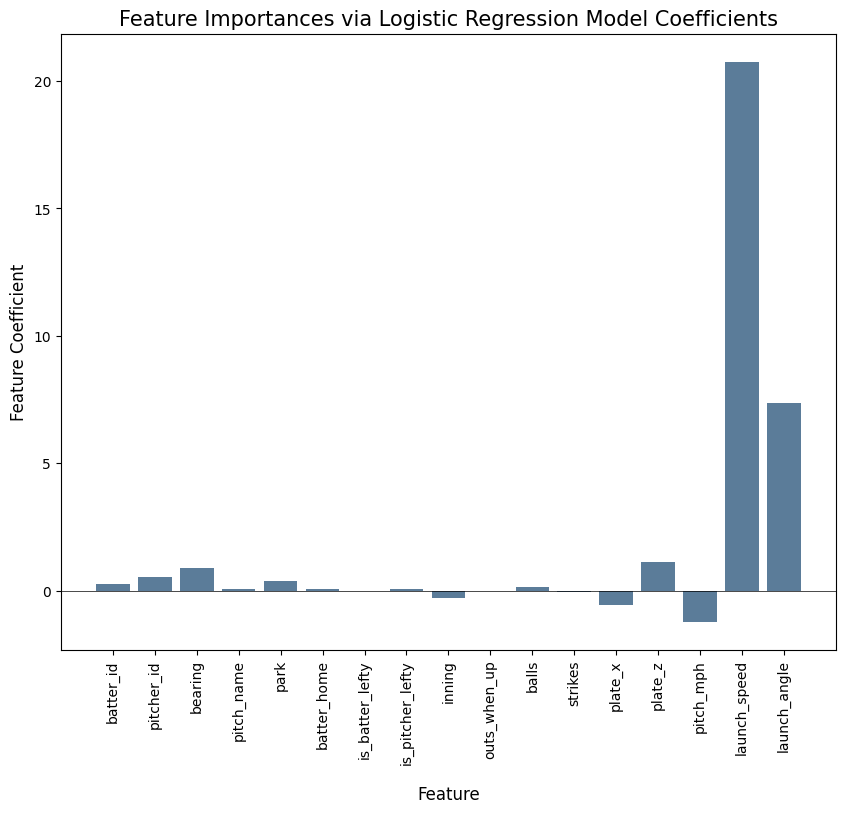

TRAIN Dataset Permutation Feature Importances:


,Mean_Importances,Importance_STDs
launch_speed,0.132672,0.002988
launch_angle,0.036527,0.001354
bearing,0.006305,0.000408
pitch_mph,0.001963,0.000280
pitcher_id,0.000973,0.000039
plate_z,0.000775,0.000171
batter_id,0.000451,0.000028
park,0.000450,0.000054
plate_x,0.000192,0.000084
inning,0.000126,0.000055


TEST Dataset Permutation Feature Importances:


,Mean_Importances,Importance_STDs
launch_speed,0.139660,0.006428
launch_angle,0.037229,0.002486
bearing,0.007478,0.000769
pitch_mph,0.001948,0.000368
plate_z,0.000888,0.000277
park,0.000293,0.000142
plate_x,0.000250,0.000133
pitcher_id,0.000211,0.000048
inning,0.000123,0.000129
batter_id,0.000103,0.000037


Saving figure...
feature_importances_via_permutation_importances.pdf saved!


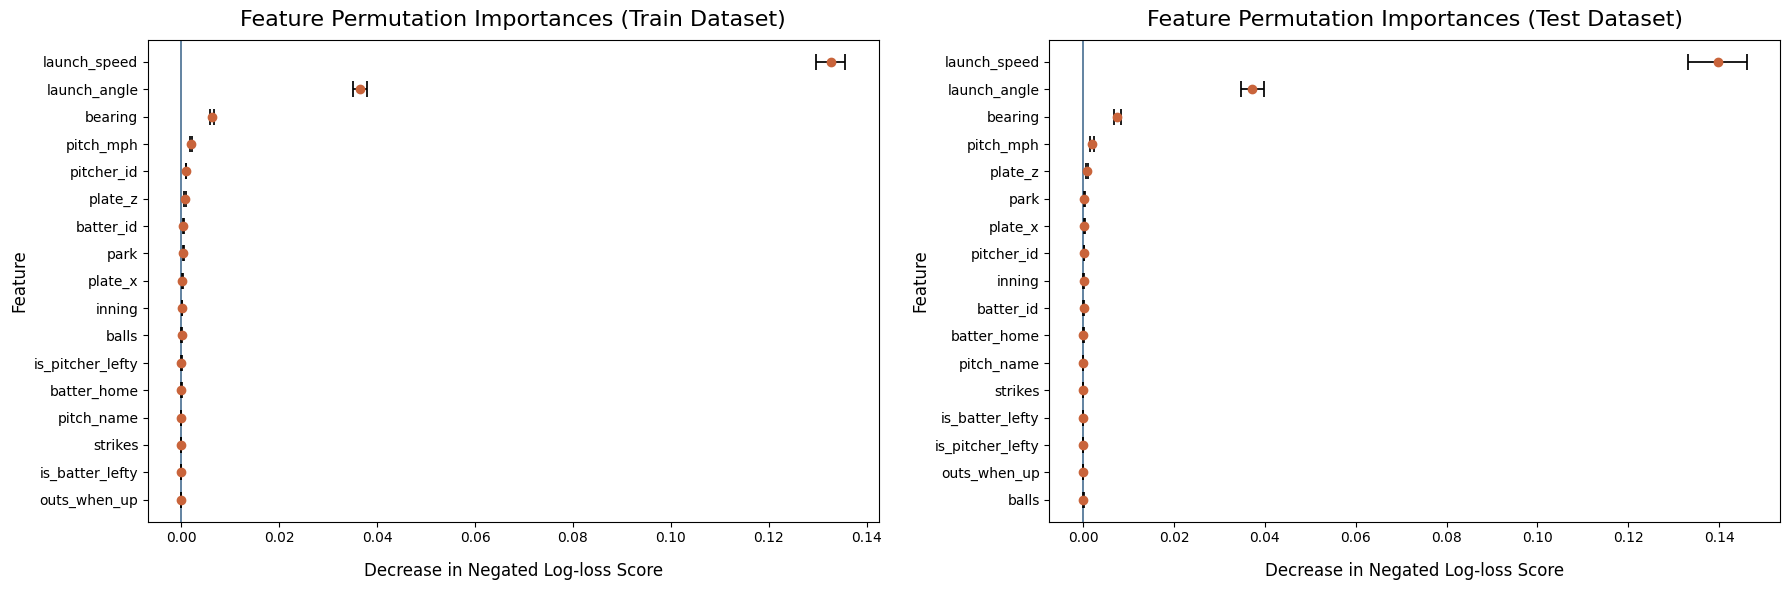

In [24]:
def error_caps(caps, width):
    for cap in caps:
        cap.set_markeredgewidth(width)
    return

##EXAMINING THE FEATURE IMPORTANCES VIA THE MODEL COEFFICIENTS

## Coefficients NOT sorted in the plot to verify the expected order of the feature names seen by the classifier.
## For some reason, despite changing the pipeline transformer outputs to DataFrames via "pipe.set_output,"
## the classifier has no attribue "feature_names_in_" so the "get_feature_names_out()" method is used with the
## previous step in the pipeline, "imputer." These should be the feature names and their order seen by the classifier.

coef_feat_importances = pd.DataFrame(
    {
     'Coefficient': best_pipe.named_steps['classifier'].coef_[0]
    },
    index=best_pipe.named_steps['preprocessor'].named_steps['imputer'].get_feature_names_out() 
)

## Printing the SORTED coefficients
display(coef_feat_importances.sort_values('Coefficient', ascending=False))

fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(coef_feat_importances.index, coef_feat_importances['Coefficient'], color='xkcd:slate blue')
ax.axhline(y = 0, linestyle='-', linewidth=0.5, color='black')
ax.set_xticklabels(coef_feat_importances.index, rotation='vertical')
ax.set_xlabel('Feature', fontsize=12, labelpad=15)
ax.set_ylabel('Feature Coefficient', fontsize=12)
ax.set_title('Feature Importances via Logistic Regression Model Coefficients', fontsize=15)

figname = 'feature_importances_via_logistic_regression_model_coefficients.pdf'

print('Saving figure...')
plt.savefig(figname)
print('{} saved!'.format(figname))

plt.show()


##EXAMINING THE FEATURE IMPORTANCES VIA PERMUTATION IMPORTANCES

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

for i, dataset in enumerate(['train', 'test']):
    permutation_importances = permutation_importance(
        best_pipe.named_steps['classifier'],
        transformed_datasets['X_'+dataset].to_numpy(),
        transformed_datasets['y_'+dataset].to_numpy(),
        scoring='neg_log_loss',
        n_repeats=20,
        n_jobs=4,
        random_state=0
    )

    sorted_importances_idx = permutation_importances.importances_mean.argsort()
    feature_importances = pd.DataFrame(
        {
            'Mean_Importances': permutation_importances.importances_mean[sorted_importances_idx],
            'Importance_STDs':  permutation_importances.importances_std[sorted_importances_idx]
        },
        index=transformed_datasets['X_'+dataset].columns[sorted_importances_idx]
    )
    
    print(dataset.upper()+' Dataset Permutation Feature Importances:')
    display(feature_importances.sort_values('Mean_Importances', ascending=False))
    
    (_, caps, _) = axs[i].errorbar(
        feature_importances['Mean_Importances'], 
        feature_importances.index, 
        xerr=feature_importances['Importance_STDs'], 
        fmt='o', 
        color='xkcd:terra cotta', 
        markersize=6, 
        ecolor='black',
        elinewidth=1.25,
        capsize=6,
        zorder=100
    )
    
    error_caps(caps, 1.25)
    
    axs[i].axvline(x = 0., color='xkcd:cadet blue', linestyle='-', linewidth=1.25)
    
    axs[i].set_title('Feature Permutation Importances ({} Dataset)'.format(dataset.capitalize()), fontsize=16, pad=10)
    axs[i].set_xlabel('Decrease in Negated Log-loss Score', fontsize=12, labelpad=12)
    axs[i].set_ylabel('Feature', fontsize=12)

plt.tight_layout(w_pad=2)

figname = 'feature_importances_via_permutation_importances.pdf'

print('Saving figure...')
plt.savefig(figname)
print('{} saved!'.format(figname))

plt.show()

## Create Custom Target Encoder<br>

This variation of a Target Encoder will have its smoothing based on the number count of a given category  
within a feature instead of the empirical Bayes estimate of the [scikit-learn Target Encoder](https://scikit-learn.org/stable/modules/preprocessing.html#target-encoder),  
which uses the following encoding $S_i$ for binary classification targets:  
<br>
$S_i=\lambda_i\frac{n_{iy}}{n_i}+(1-\lambda_i)\frac{n_y}{n}$  
<br>
&emsp;$\lambda_i=\frac{n_i}{m_i+n_i}$ : The shrinkage factor  
&emsp;&emsp;$m_i=\sigma_i^2/\tau^2$ : The smoothing factor  
&emsp;&emsp;$\sigma_i^2$ : The variance of $y$ with category $i$  
&emsp;&emsp;$\tau^2$ : The global variance of $y$  
&emsp;$n_{iy}$ : The number of observations with $y=1$ and category $i$  
&emsp;$n_i$ : The number of observations with category $i$  
&emsp;$n_y$ : The number of all observations with $y=1$  
&emsp;$n$ : The number of all observations  
<br>
Given that the target is binary in this problem, many feature categories, specifically categories  
in the features `batter_id` and `pitcher_id`, have variances of $\sigma_i^2=0$.  
This causes the shrinkage factor in the scikit-learn implementation to be $\lambda_i=1$,  
and the encoding to simplify to the category target mean $S_i=\frac{n_{iy}}{n_i}$,  
ignoring the contributions of the global target mean $\frac{n_y}{n}$.  
<br>
**This is a problem when considering batters or pitchers who do not make many appearances in this  
dataset and thus would have statistics that likely are not representative of reality should they  
have more appearances.**  
<br>
**Here I create a custom Target Encoder based on this example [here](https://towardsdatascience.com/encoding-categorical-variables-a-deep-dive-into-target-encoding-2862217c2753) which bases the shrinkage factor $\lambda_i$  
on the number of instances of a given category in a feature, so that lower (higher) counts have  
encodings that weight more heavily toward the global (category) target mean.**  
<br>
$\lambda_i=\frac{1}{1+e^{\frac{-(n_i-k)}{f}}}$  
<br>
&emsp;$n_i$ : The number of counts of the category $i$ in the feature  
&emsp;$k$ : The value (number of counts) where $\lambda_i=0.5$  
&emsp;$f$ : The value that controls how quickly the function increases from 0 to 1 around $k$ counts  
<br>
However, instead of adding random noise to the encodings as in the above example, this Target Encoder  
will still employ the cross-fitting strategy when using the `.fit_transform(X, y)` method as in the  
scikit-learn implementation. When using `.fit(X, y).transform(X)`, one encoding will be learned  
on the entire training set as in the scikit-learn implementation. The type of the returned, transformed,  
features is kept as `ndarray` for consistency. I have added some attributes to the class, however.  
<br>
There are no missing values in the features I wish to encode with this custom encoder,  
so I do not worry about this at this time. Categories not seen in fitting but present when transforming  
are assigned the global target mean from the training set as in the scikit-learn implementation.

In [ ]:
# Testing out the custom Target Encode

# cols = ['batter_id', 'pitcher_id']

# te = TargetEncode(cat_features=cols, lambda05='median', flattening_factor=25, random_state=0)

# test = te.fit_transform(batting_df[cols], batting_df['is_home_run'])

# test_df = pd.DataFrame(test, columns=cols)

# display(test_df)
# print(test_df.dtypes)
# print('\n\n')

# for attribute, value in te.__dict__.items():
#     print('Attribute: ', attribute)
#     print('Value: ', value)
#     print()

In [ ]:
# display(test.round(5))
# display(test2.round(5))
# test.round(5).equals(test2.round(5))

In [ ]:
# https://www.omnicalculator.com/statistics/hypergeometric-distribution

In [ ]:
# def hr_percentage(group, which):
#     group[which+'_hr_perc'] = np.zeros(len(group))

#     for i in range(1, len(group)):
#         group[which+'_hr_perc'].iloc[i] = group['is_home_run'].iloc[:i].mean()
# #     display(group)
#     return group

## Converting "game_date" column from dtype Object to dtype datetime64
# batting_df.loc[:, 'game_date'] = pd.to_datetime(batting_df['game_date'])
# print(batting_df['game_date'].dtype)
## Sorting the DataFrame by ("game_date", "inning", and "outs_when_up")
# batting_df = batting_df.sort_values(['game_date', 'inning', 'outs_when_up'], ascending=True, ignore_index=True)
# print('Sorted DataFrame before any feature engineering - sorted by ("game_date", "inning", "outs_when_up"):')
# display(batting_df.head(20))

## Creating a column for both the batter and pitcher reflecting the percentage of hits or hits allowed,
## up to but not including the current entry, by that player that are home runs.
## This is done after sorting the DataFrame by ("game_date", "inning", and "outs_when_up")
## HOWEVER, without specific timestamps, batting orders, etc. it is possible that a batter has more than one
## hit (one of which being a home run) during the same inning with the same number of outs 
## (very unlikely but possible) or a pitcher gives up one or more home runs over multiple hits allowed
## in the same inning with the same number of outs (somewhat unlikely but possible). In these edge cases,
## the order of the hits without and for a home run may not be chronological, slightly affecting the 
## calculated home run percentage (vs. actual home run percentage) up to that point in time 
# batting_df = (batting_df
#               .groupby('batter_name', as_index=False, sort=False)
#               .apply(lambda x: hr_percentage(x, which='batter'))
#               .sort_values(['game_date', 'inning', 'outs_when_up'], ascending=True, ignore_index=True)
#              )
# batting_df = (batting_df
#               .groupby('pitcher_name', as_index=False, sort=False)
#               .apply(lambda x: hr_percentage(x, which='pitcher'))
#               .sort_values(['game_date', 'inning', 'outs_when_up'], ascending=True, ignore_index=True)
#              )

## Removing the entries that have BOTH missing launch speed and missing launch angle
## Together, these two features should by far be the most predictive of the target "is_home_run"
## If both are missing, even with imputation, I worry the performance of the estimator might suffer
## if these entries with both missing values are retained
# batting_df = batting_df[~((batting_df['launch_angle'].isna()) & 
#                           (batting_df['launch_speed'].isna())
#                          )
#                        ]